In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, confusion_matrix
import os
import re

In [2]:
authors_short_dict = {"MWS": "Mary Shelley", "HPL": "H. P. Lovecraft", "EAP": "Edgar Allan Poe"}
df = pd.DataFrame(pd.read_json("preprocessing_output/preprocessed_test_W.json").author)
df["author_short"] = df.author
df.author = df.author.apply(lambda x: authors_short_dict[x])
for filename in os.listdir("results_output/"):
    fileparts = filename.split("_")
    method = fileparts[1]
    if "template" in method:
        continue
    preprocessing = ".".join(fileparts[2].split(".")[:-1])
    df[f"{method} with {preprocessing}"] = pd.read_json(f"results_output/results_{method}_{preprocessing}.json")
df


,author,author_short,lda with CSP,bayes with WSP,lda with CSPH1e-5,bayes with WSPH1e-4,lda with WL,bayes with WSPH1e-5,bayes with C,lda with C,...,bayes with CSPH1e-6,bayes with CSPH5e-5,bayes with WSPH5e-5,lda with CSPH1e-6,bayes with CSPH1e-5,lda with CSPH5e-5,lda with CSPH1e-4,bayes with WSPH5e-4,lda with WSPH5e-5,bayes with CSP
0,Edgar Allan Poe,EAP,EAP,EAP,EAP,EAP,EAP,EAP,EAP,EAP,...,EAP,EAP,EAP,EAP,EAP,EAP,EAP,EAP,EAP,EAP
1,Edgar Allan Poe,EAP,HPL,HPL,HPL,HPL,HPL,HPL,HPL,HPL,...,HPL,HPL,HPL,HPL,HPL,HPL,HPL,HPL,HPL,HPL
2,H. P. Lovecraft,HPL,MWS,MWS,MWS,MWS,MWS,MWS,MWS,MWS,...,MWS,MWS,MWS,MWS,MWS,MWS,MWS,MWS,MWS,MWS
3,Mary Shelley,MWS,HPL,HPL,HPL,HPL,HPL,HPL,HPL,HPL,...,HPL,HPL,HPL,HPL,HPL,HPL,HPL,HPL,HPL,HPL
4,H. P. Lovecraft,HPL,HPL,HPL,HPL,HPL,HPL,HPL,HPL,HPL,...,HPL,HPL,HPL,HPL,HPL,HPL,HPL,HPL,HPL,HPL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3911,Edgar Allan Poe,EAP,HPL,HPL,HPL,HPL,HPL,HPL,HPL,HPL,...,HPL,HPL,HPL,HPL,HPL,HPL,HPL,HPL,HPL,HPL
3912,Edgar Allan Poe,EAP,EAP,EAP,EAP,EAP,EAP,EAP,EAP,EAP,...,EAP,EAP,EAP,EAP,EAP,EAP,EAP,EAP,EAP,EAP
3913,Mary Shelley,MWS,HPL,HPL,HPL,HPL,HPL,HPL,HPL,HPL,...,HPL,HPL,HPL,HPL,HPL,HPL,HPL,HPL,HPL,HPL
3914,H. P. Lovecraft,HPL,MWS,MWS,MWS,MWS,MWS,MWS,MWS,MWS,...,MWS,MWS,MWS,MWS,MWS,MWS,MWS,MWS,MWS,MWS


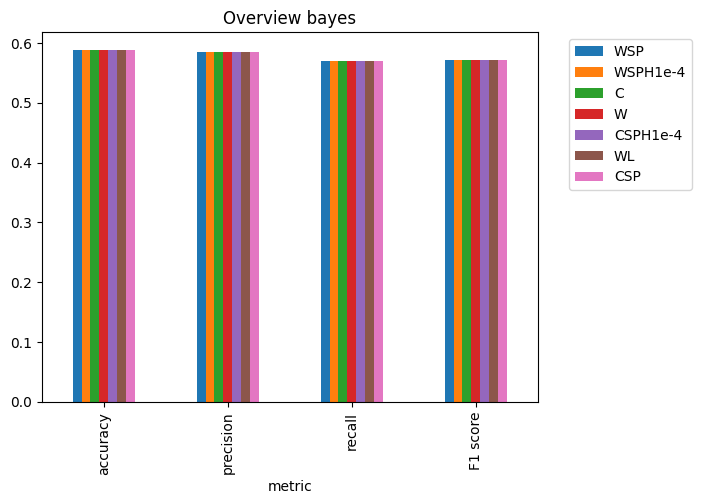

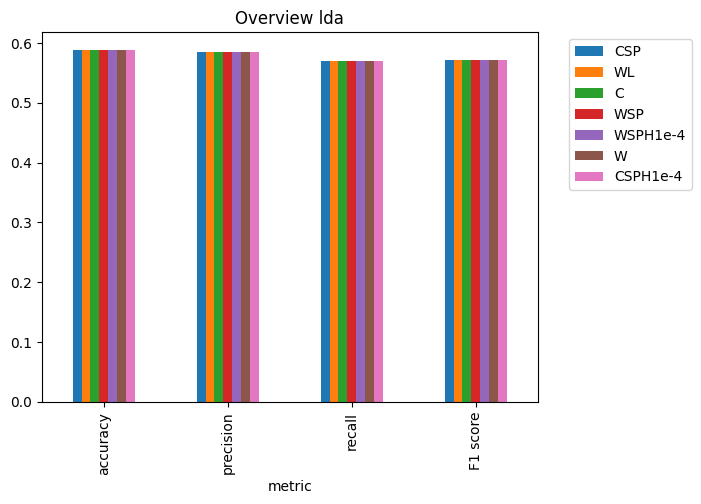

In [3]:
for method in ["bayes", "lda"]:
    method_df = df.loc[:, df.columns.str.contains(f"^(?:(?=.*\\b(?:author|{method}|author_short)\\b)(?:(?![56]).)*)$")]
    method_df = method_df.rename(columns=lambda x: re.sub(r".*\s(\S+)$", r"\1", x))
    score_df = method_df.iloc[: , 2:].apply(lambda x: [accuracy_score(x, method_df["author_short"]), precision_score(method_df["author_short"], x, average="macro"), recall_score(method_df["author_short"], x, average="macro"), f1_score(method_df["author_short"], x, average="macro")])
    score_df["metric"] = ["accuracy", "precision", "recall", "F1 score"]
    score_df.plot.bar("metric", title=f"Overview {method}")
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

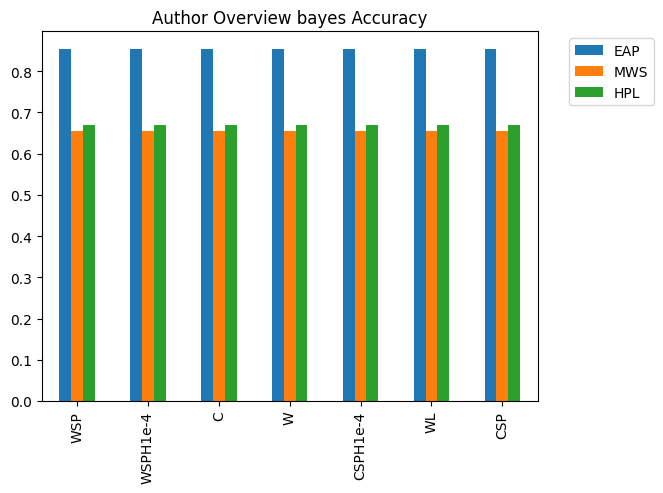

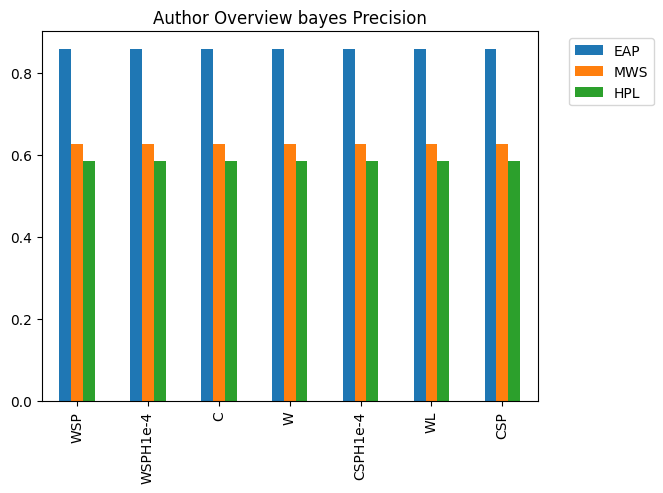

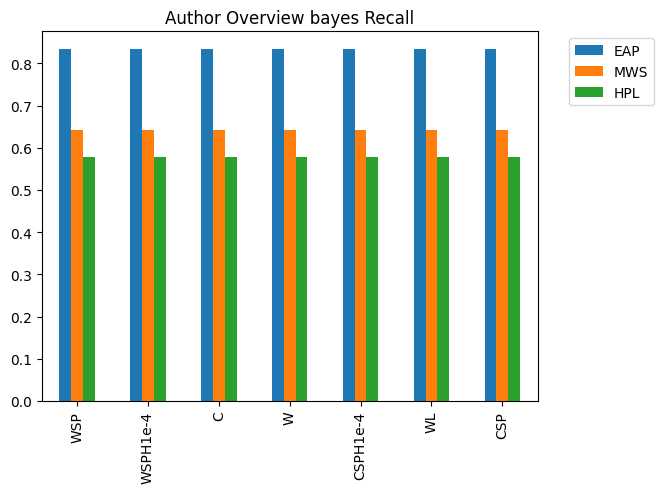

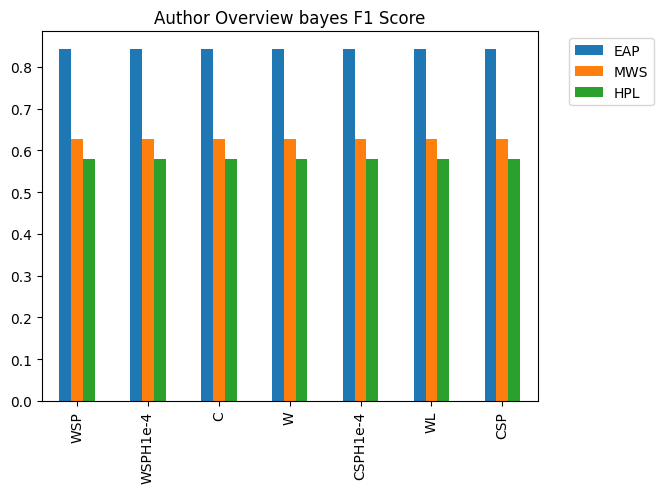

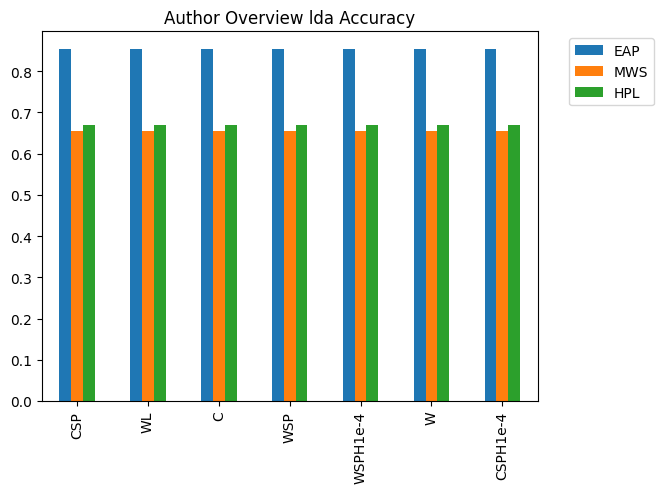

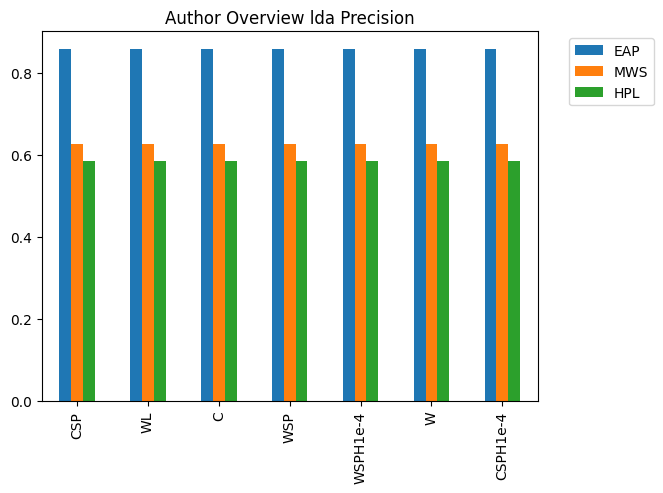

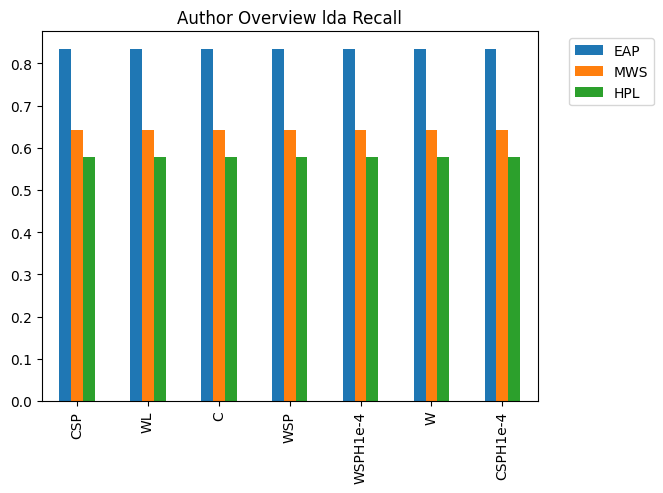

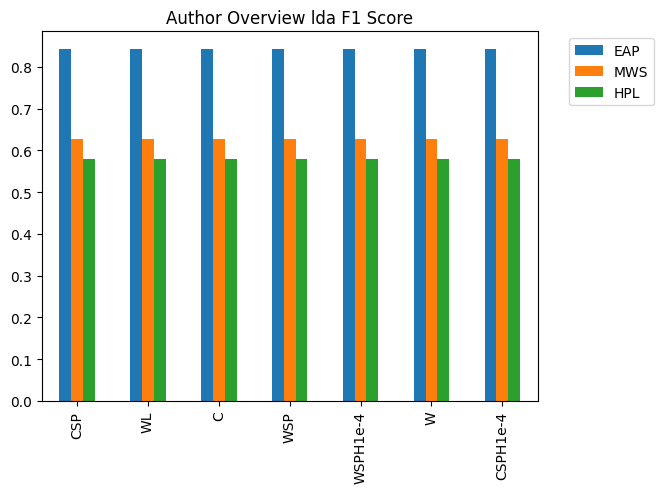

In [4]:
from collections import defaultdict

metrics = [("Accuracy", accuracy_score), ("Precision", lambda x, y: precision_score(x, y, average="macro")), ("Recall",
                                                                                                              lambda x, y: recall_score(x, y, average="macro")), ("F1 Score", lambda x, y: f1_score(x, y, average="macro"))]
for method in ["bayes", "lda"]:
    for (name, func) in metrics:
        score_df = {}
        method_df = df.loc[:, df.columns.str.contains(
            f"^(?:(?=.*\\b(?:author|{method}|author_short)\\b)(?:(?![56]).)*)$")]
        for author in ["EAP", "MWS", "HPL"]:
            author_df = pd.DataFrame(
                {"author": method_df["author"]})
            author_df = pd.concat([author_df, method_df.iloc[:, 1:].apply(
                lambda x: [1 if author == i else 0 for i in x])], axis=1)
            author_df = author_df.rename(columns=lambda x: re.sub(r".*\s(\S+)$", r"\1", x))
            score_df[author] = author_df.iloc[:, 2:].apply(
                lambda x: func(author_df["author_short"], x))
        score_df = pd.DataFrame(score_df)
        score_df.plot.bar(title=f"Author Overview {method} {name}")
        plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')


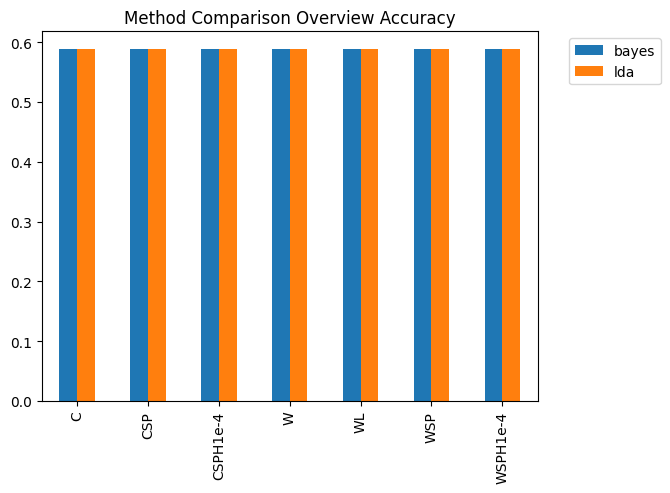

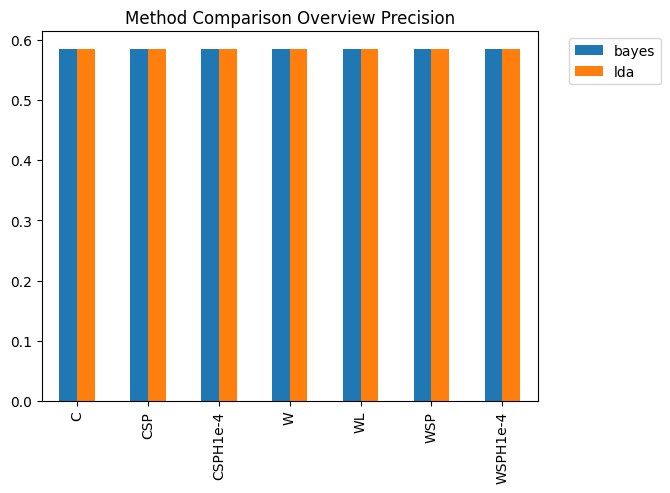

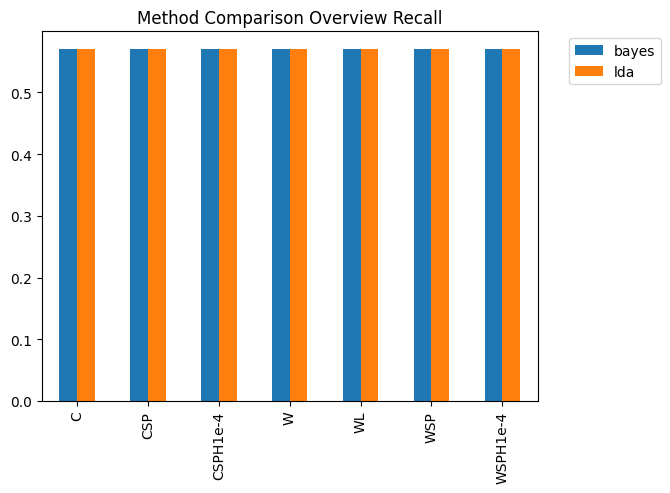

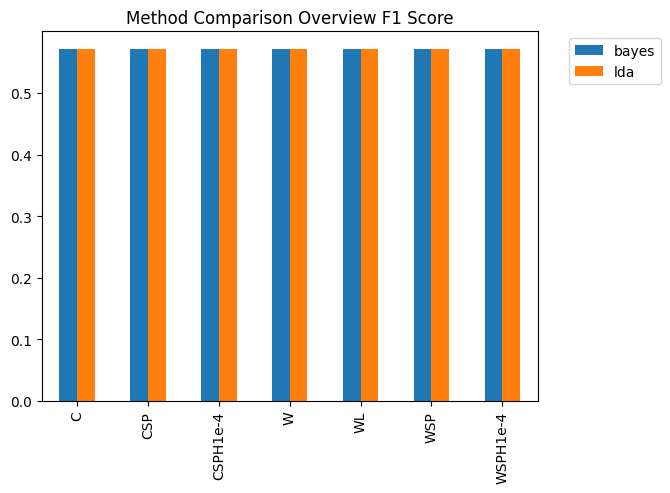

In [5]:
for (name, func) in metrics:
    preprocess_df = {}
    for method in ["bayes", "lda"]:
        score_df = df.loc[:, df.columns.str.contains(f"^(?:(?=.*\\b(?:author|{method}|author_short)\\b)(?:(?![56]).)*)$")]
        score_df = score_df.rename(columns=lambda x: re.sub(r".*\s(\S+)$", r"\1", x))
        score_df = score_df.iloc[:, 2:].apply(lambda x: func(score_df["author_short"], x))
        preprocess_df[method] = score_df
    preprocess_df = pd.DataFrame(preprocess_df)
    preprocess_df.plot.bar(title=f"Method Comparison Overview {name}")
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

/tmp/ipykernel_26119/299294681.py:12: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  process_df = author_df.loc[:, author_df.columns.str.contains(f"(.*{method}.*)|(.*author.*)", regex=True)]
/tmp/ipykernel_26119/299294681.py:12: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  process_df = author_df.loc[:, author_df.columns.str.contains(f"(.*{method}.*)|(.*author.*)", regex=True)]
/tmp/ipykernel_26119/299294681.py:12: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  process_df = author_df.loc[:, author_df.columns.str.contains(f"(.*{method}.*)|(.*author.*)", regex=True)]
/tmp/ipykernel_26119/299294681.py:12: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.e

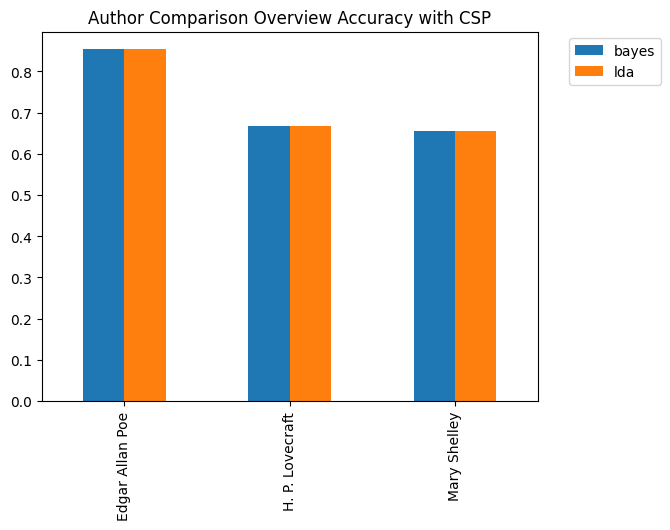

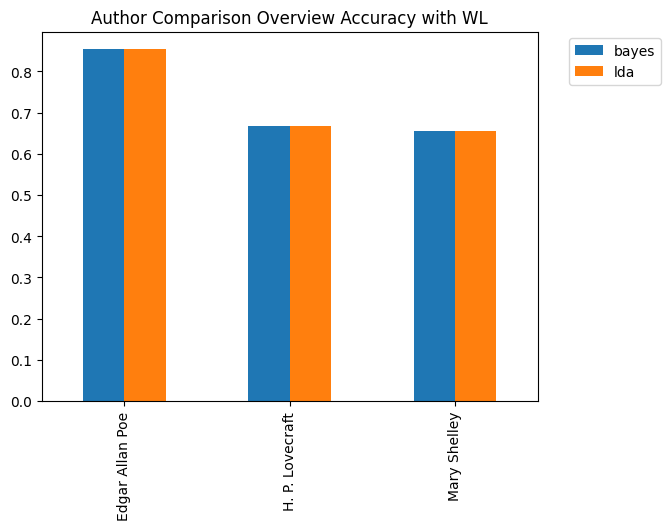

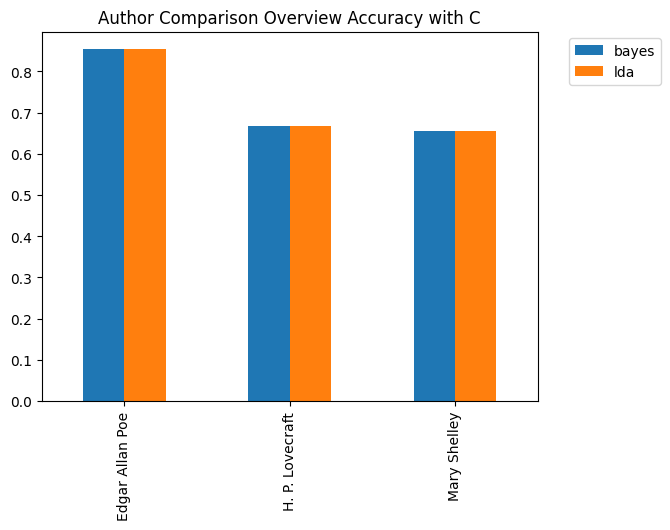

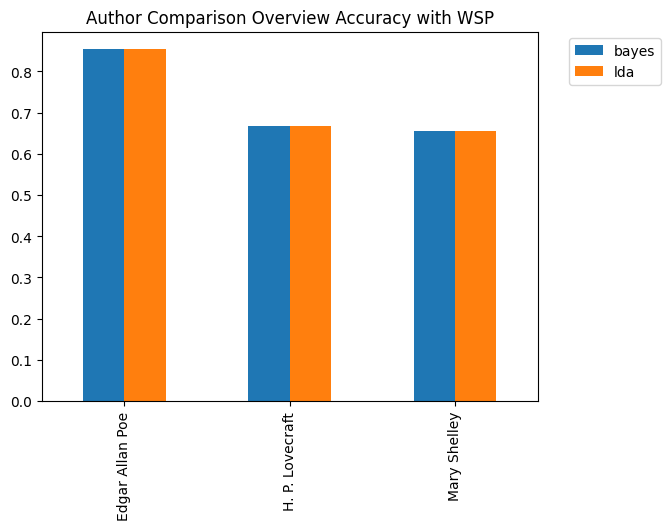

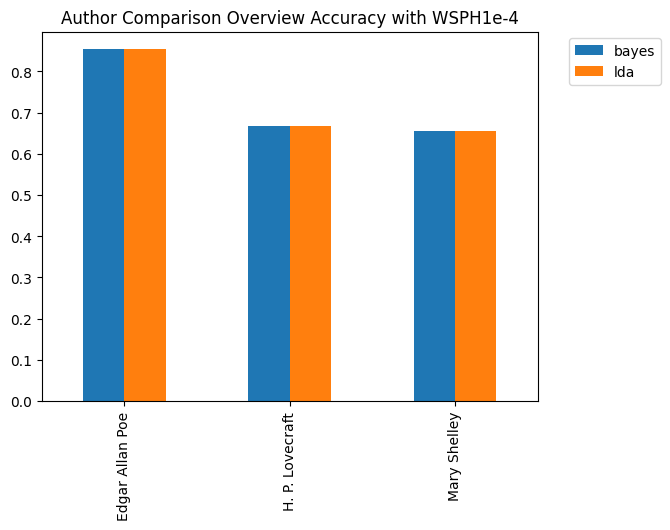

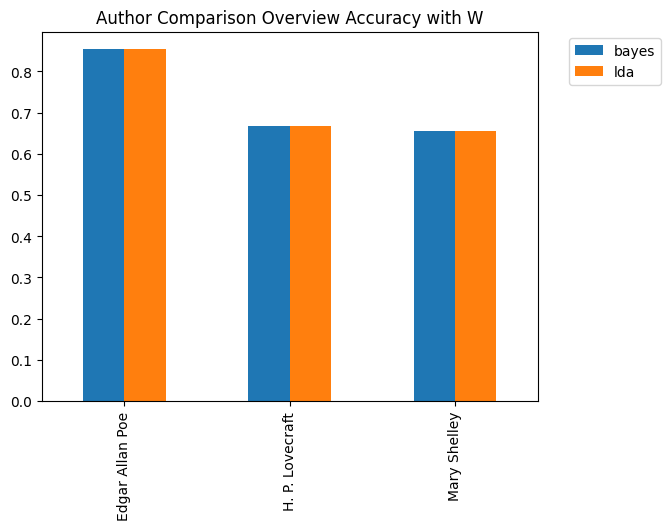

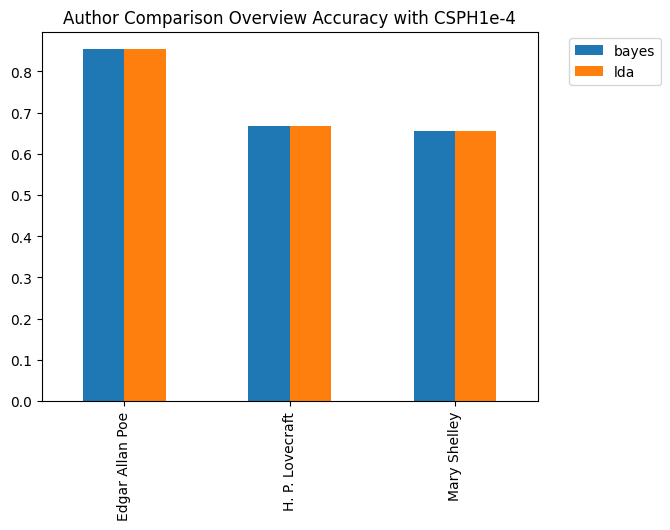

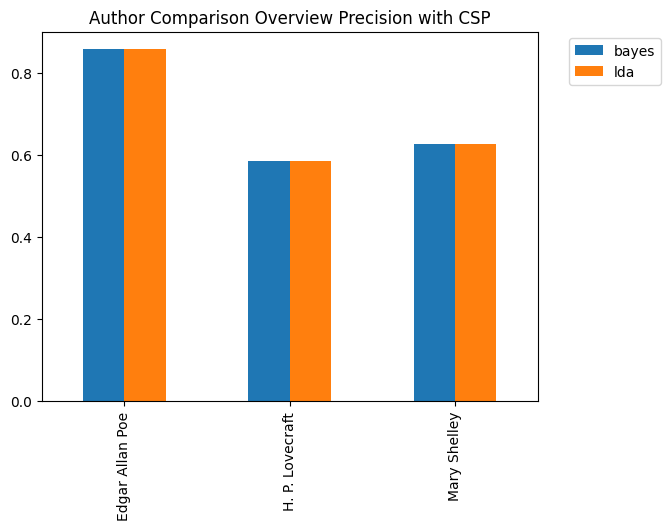

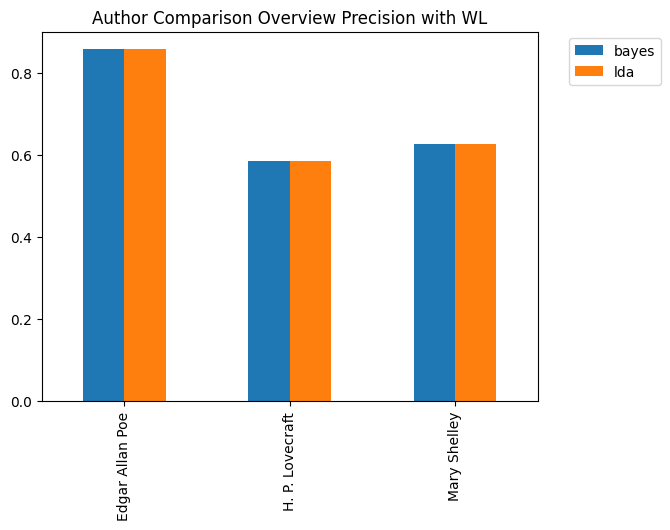

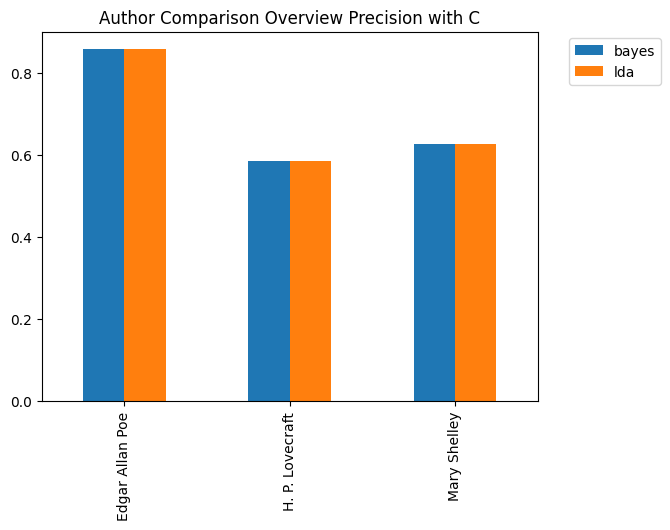

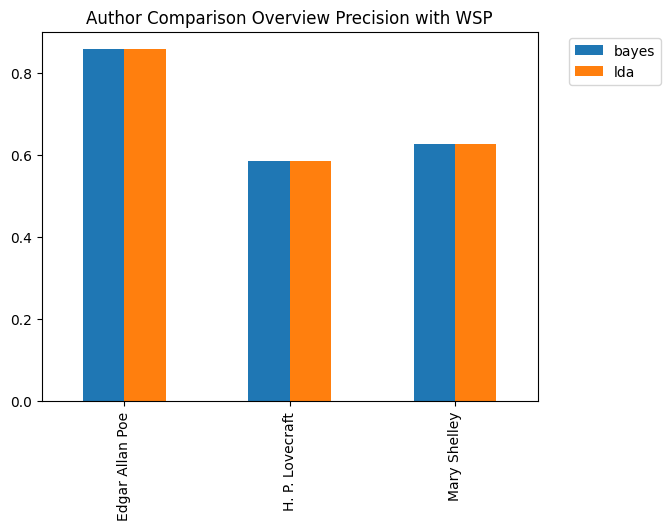

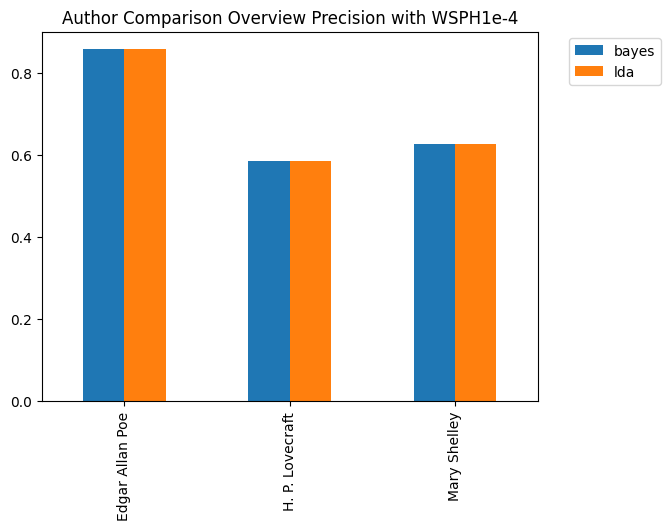

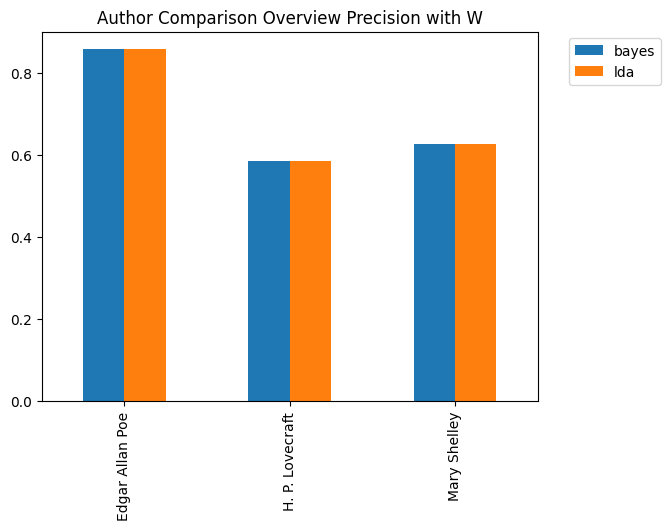

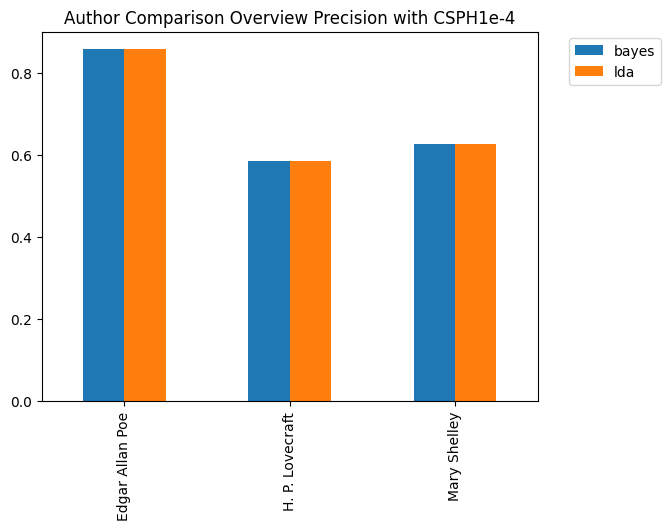

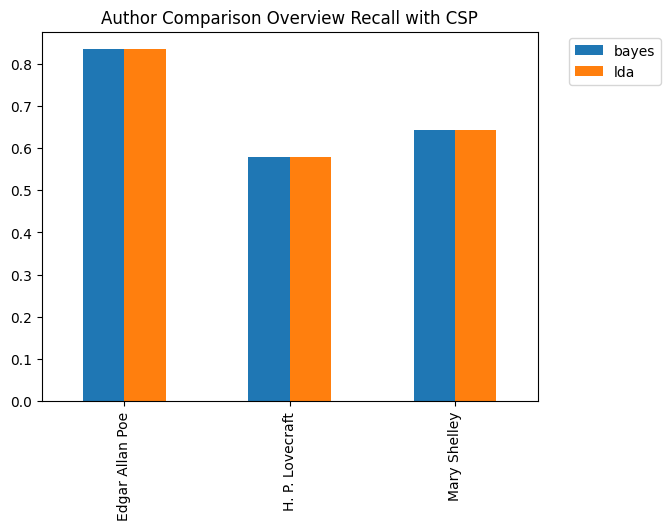

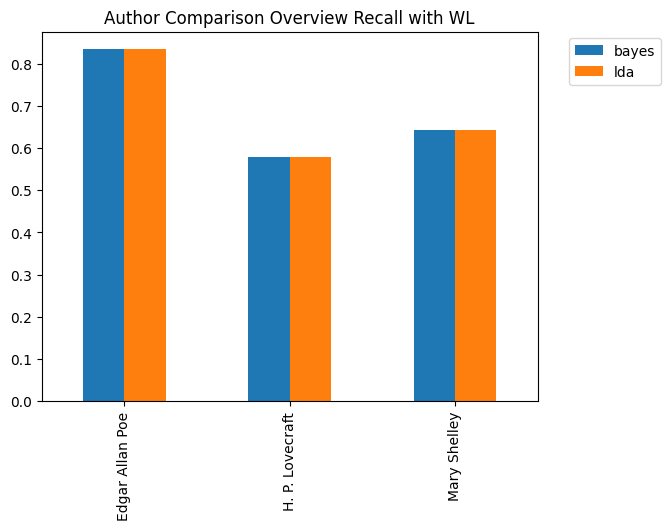

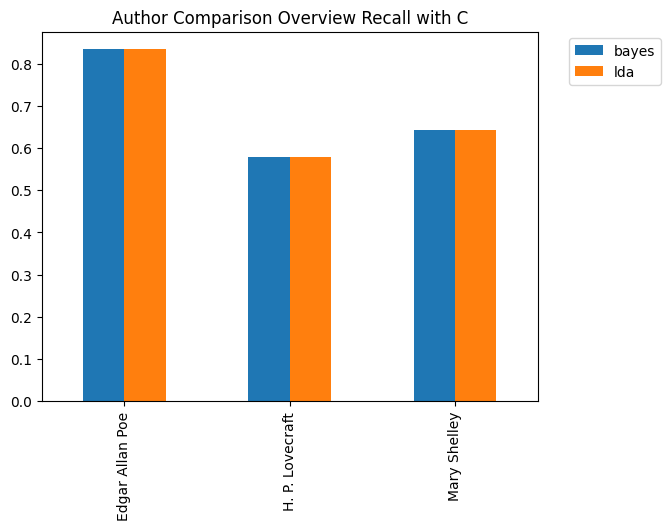

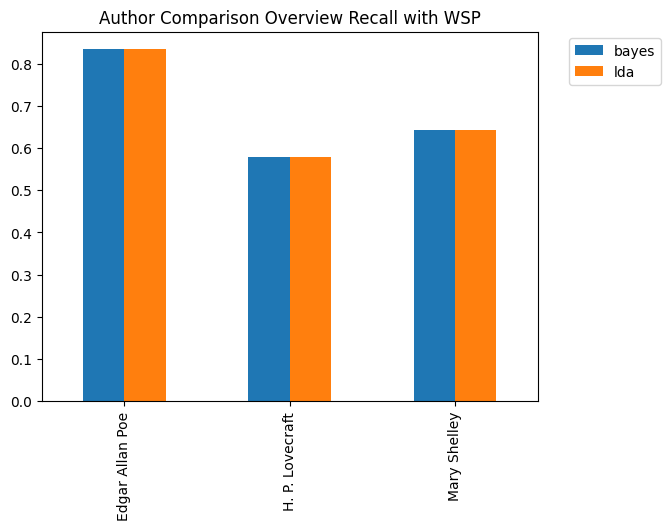

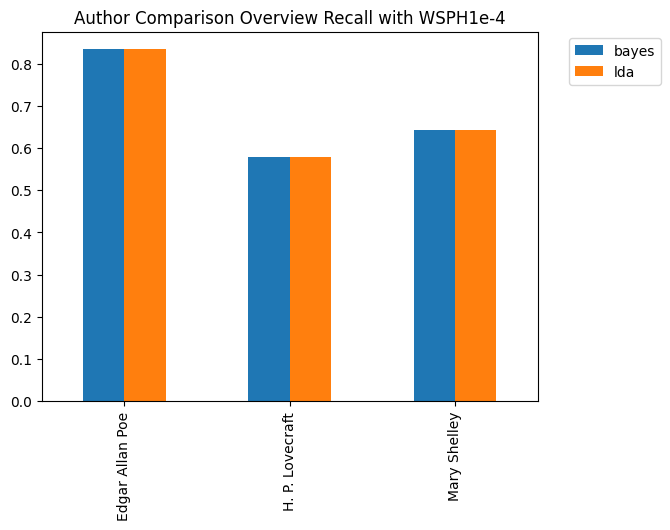

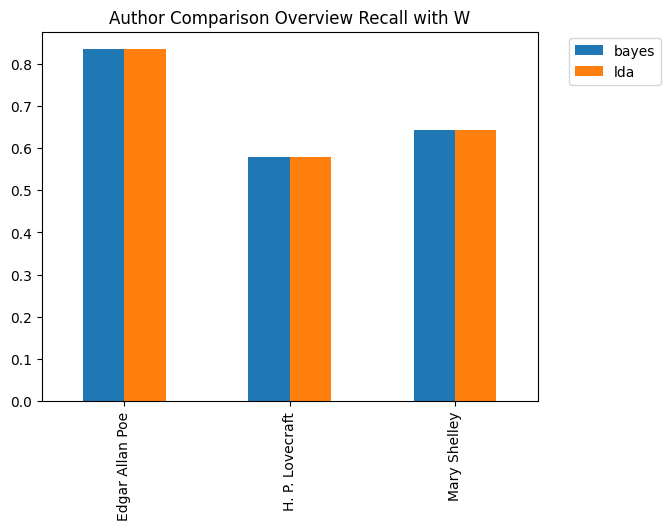

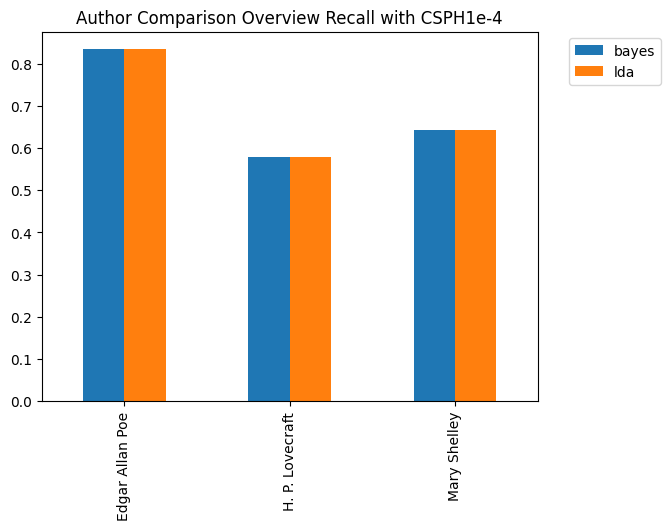

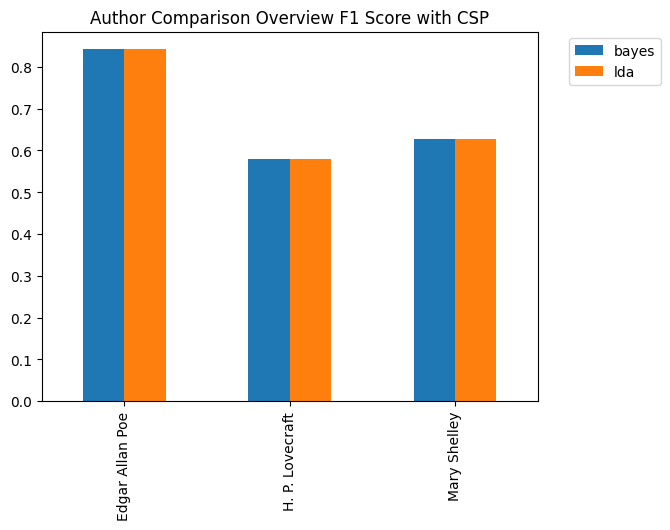

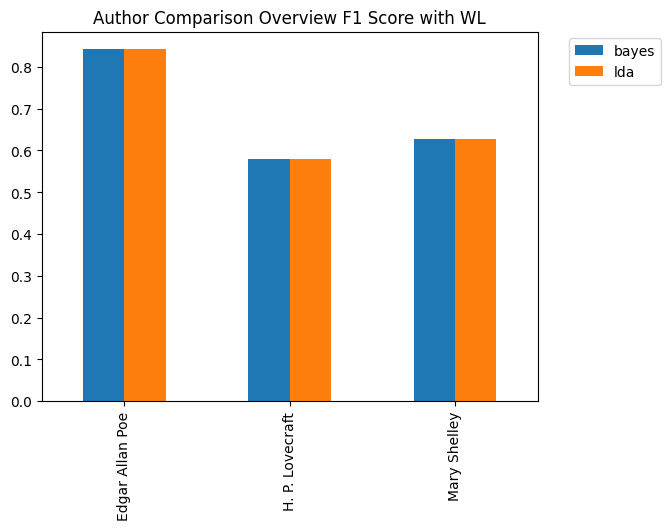

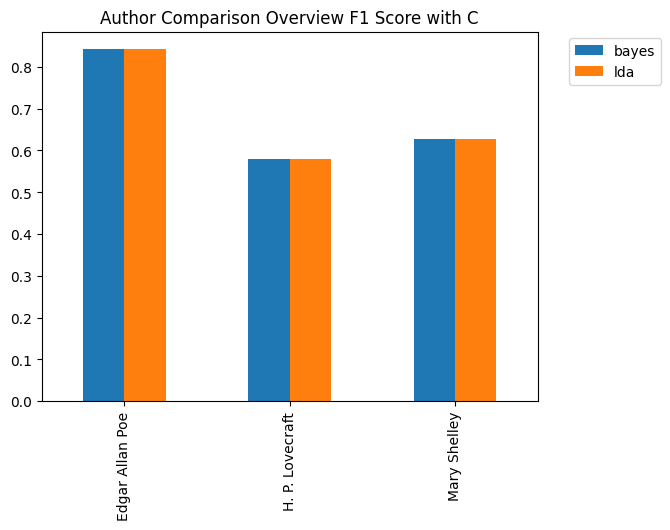

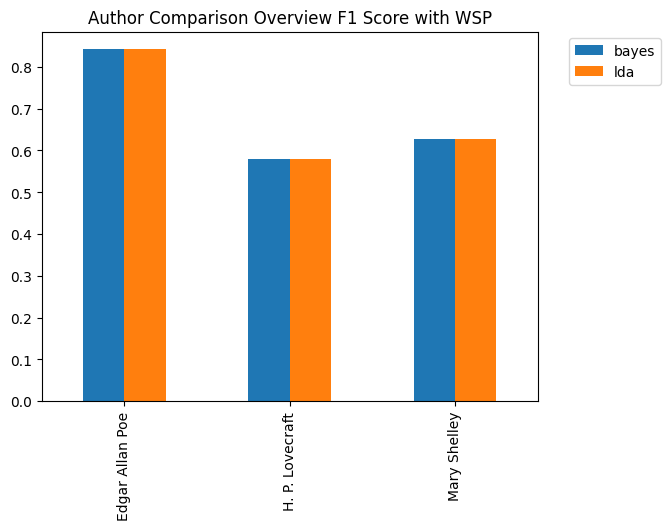

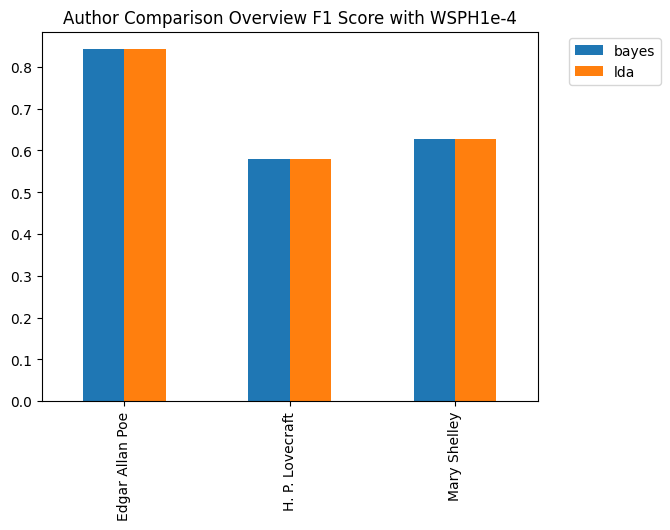

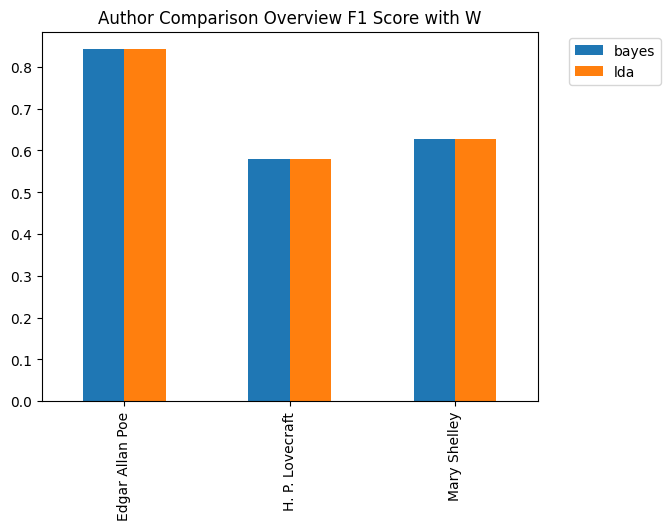

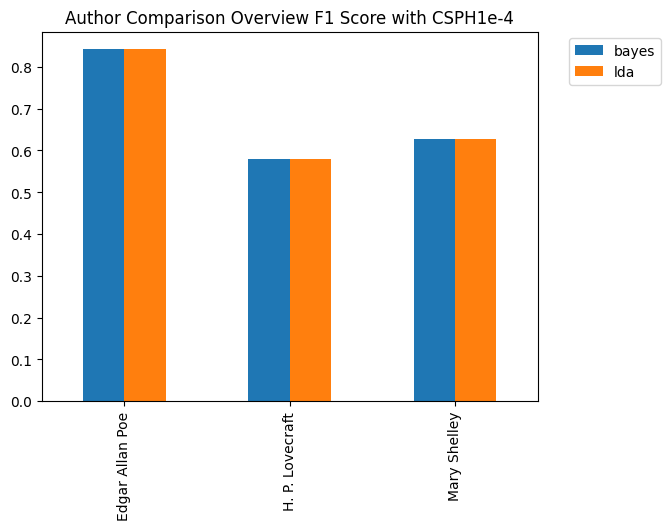

In [6]:
for (name, func) in metrics:
    method_df = df.loc[:, df.columns.str.contains(f"^[^56]*$")]
    for preprocessing in range(2,int((len(method_df.columns)) / 2 + 1)):
        authors = defaultdict(lambda: [])
        preprocess_name = ""
        for author in ["EAP", "HPL", "MWS"]:
            author_df = pd.DataFrame(
                            {"author": method_df["author"]})
            author_df = pd.concat([author_df, method_df.iloc[:, 1:].apply(
                lambda x: [1 if author == i else 0 for i in x])], axis=1)
            for method in ["bayes", "lda"]:
                process_df = author_df.loc[:, author_df.columns.str.contains(f"(.*{method}.*)|(.*author.*)", regex=True)]
                preprocess_name = re.sub(".*\s(\S+)$", r"\1", process_df.columns[preprocessing])
                authors[author].append(func(process_df["author_short"],process_df.iloc[:, preprocessing]))
        authors = pd.DataFrame(authors)
        authors = authors.rename(columns=lambda x: authors_short_dict[x])
        authors["method"] = ["bayes", "lda"]
        authors = authors.pivot_table(columns ="method")
        authors.plot.bar(title=f"Author Comparison Overview {name} with {preprocess_name}")
        plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

/tmp/ipykernel_26119/579560021.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  method_df = df.loc[:, df.columns.str.contains(f"(author|{method})")]
/tmp/ipykernel_26119/579560021.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  method_df = df.loc[:, df.columns.str.contains(f"(author|{method})")]
/home/tristan/.local/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:512: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


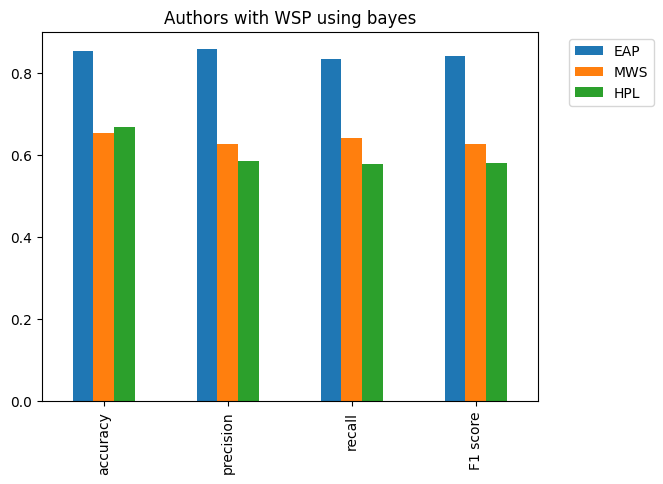

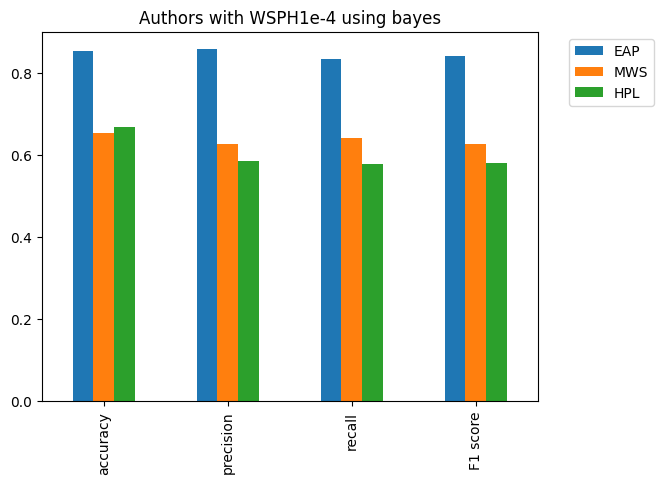

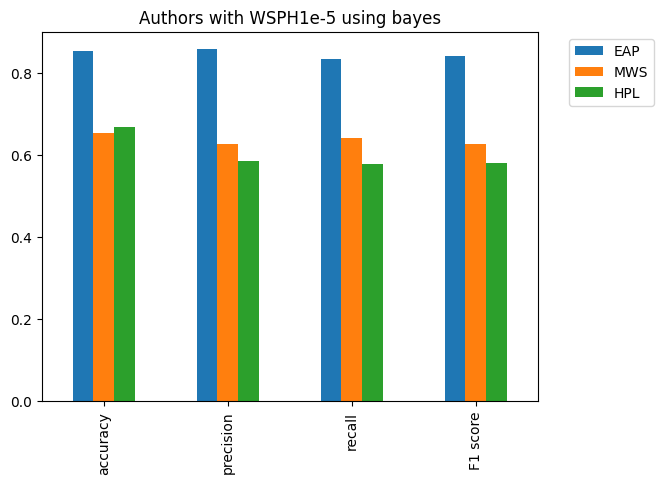

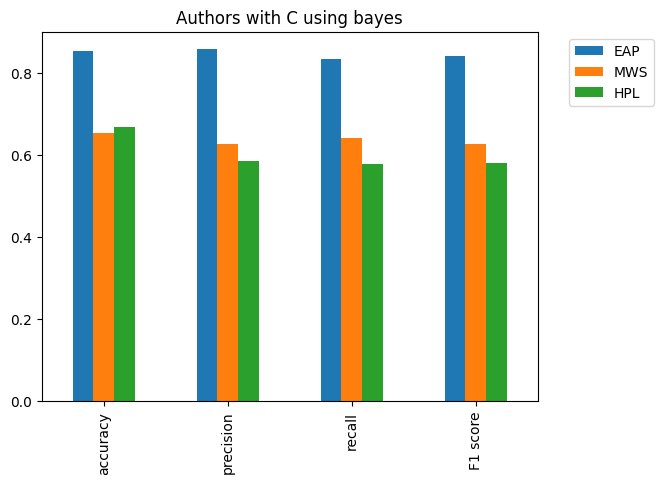

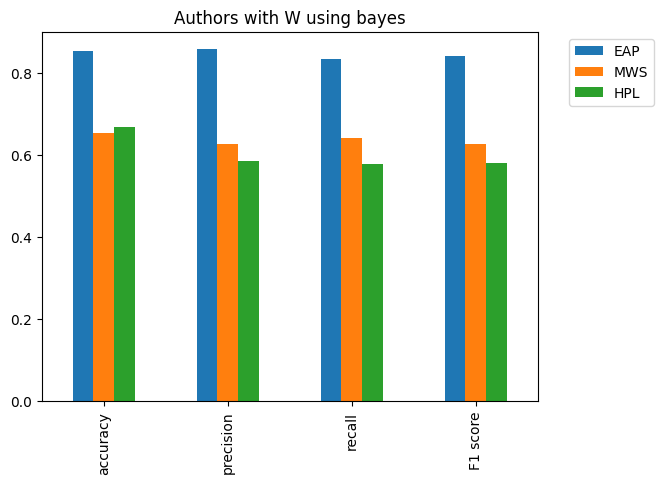

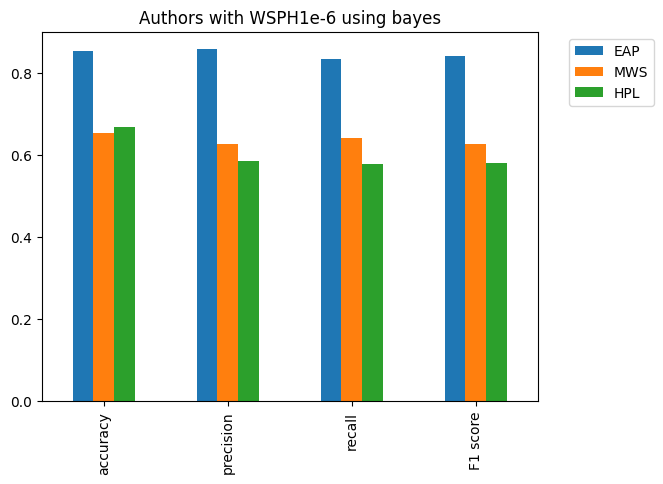

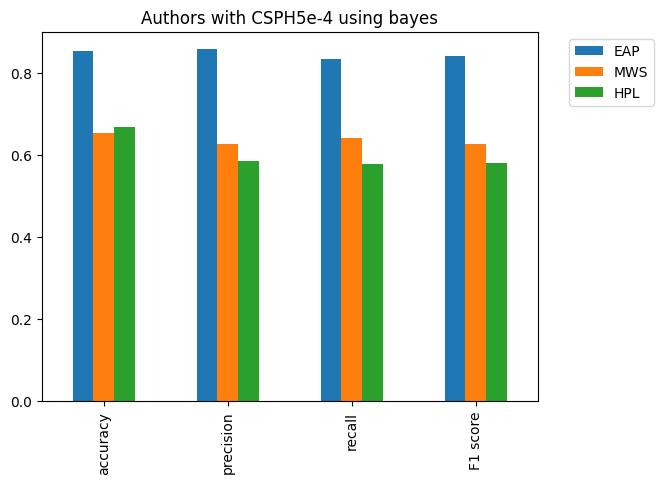

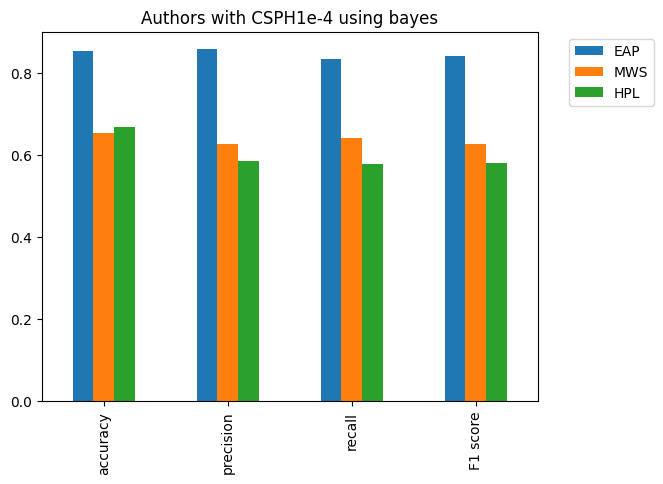

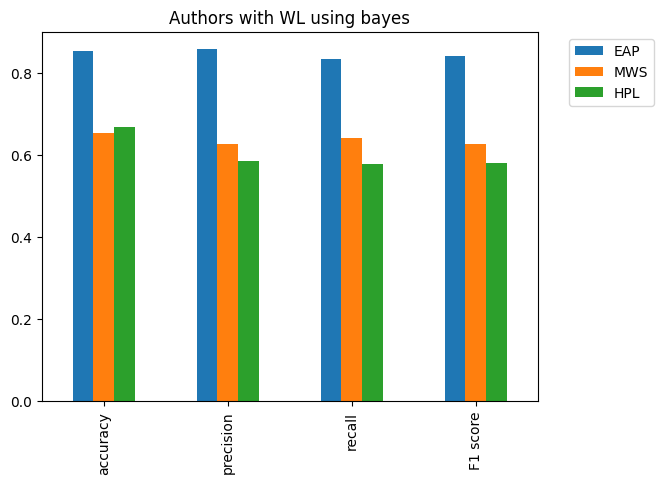

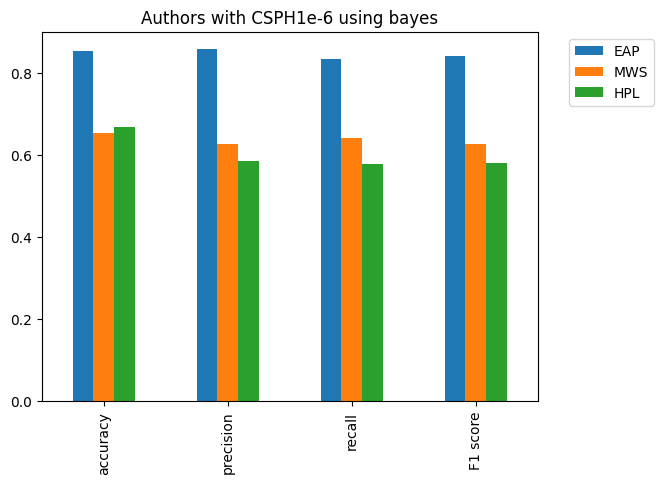

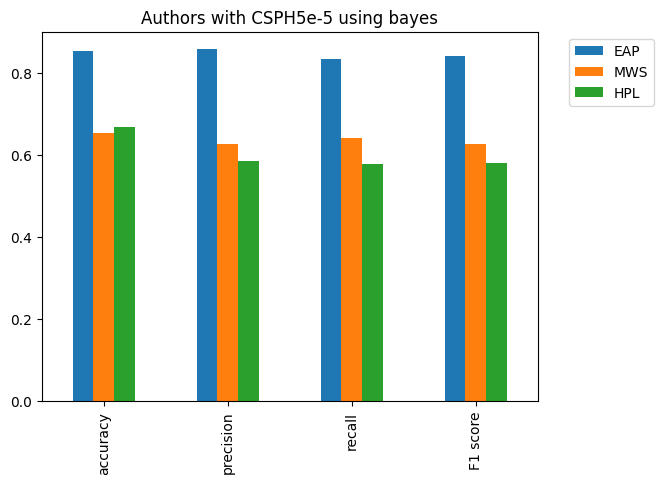

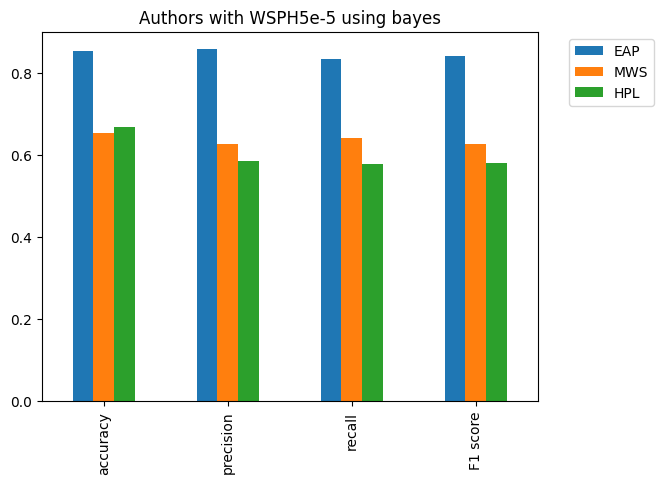

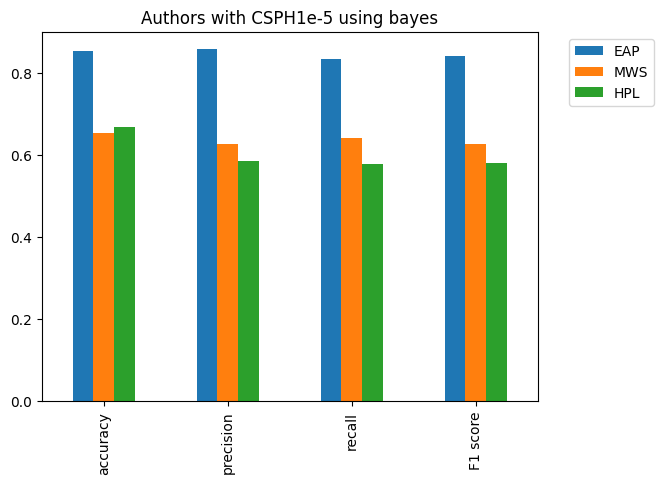

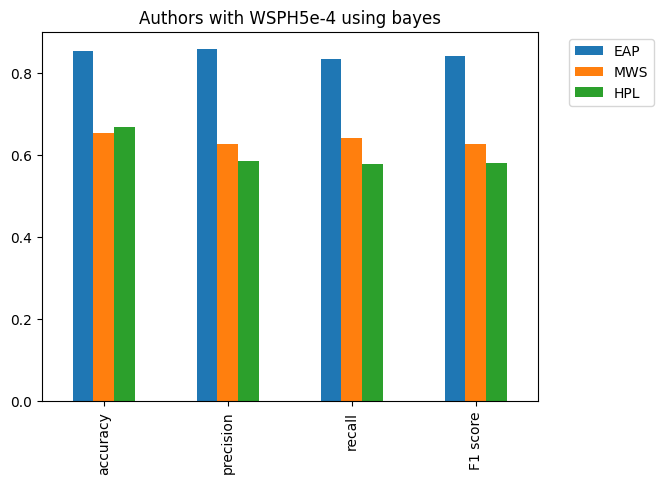

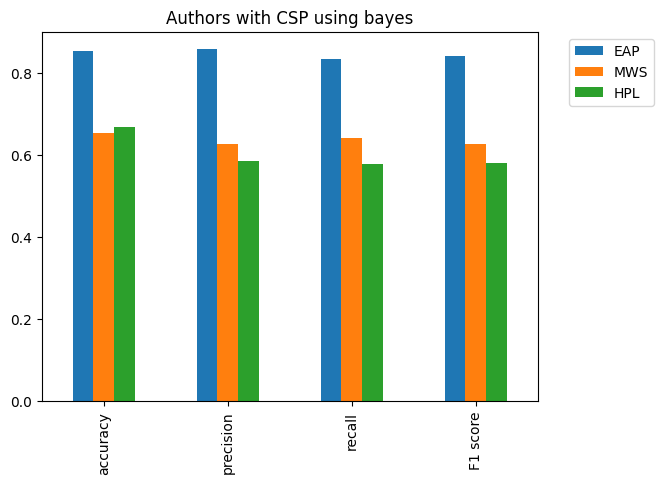

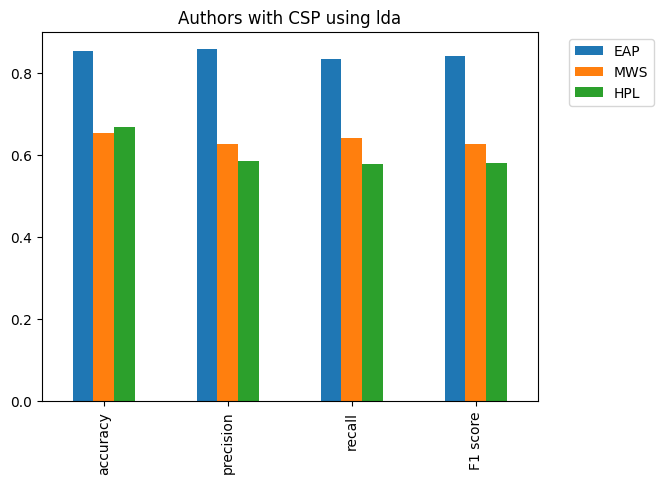

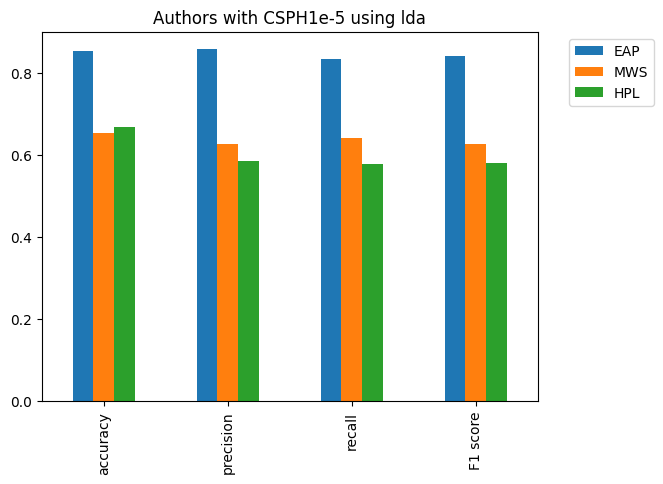

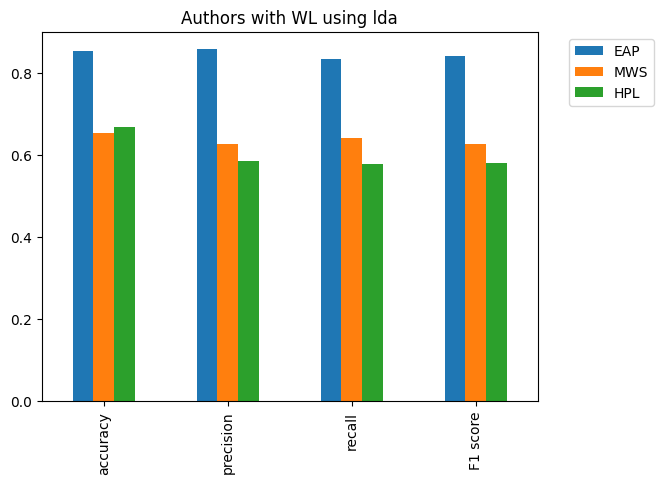

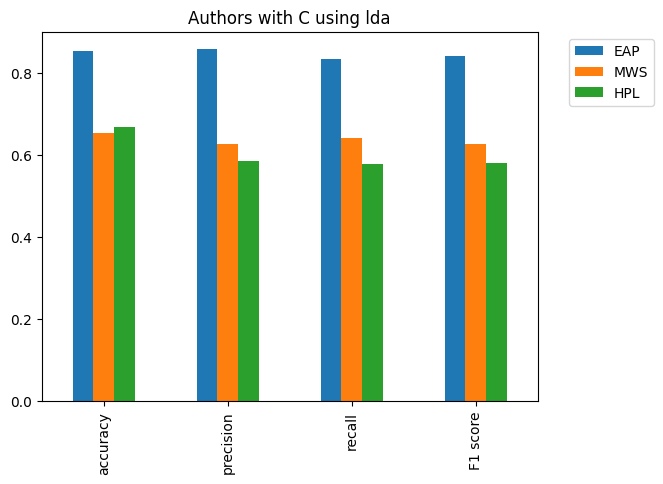

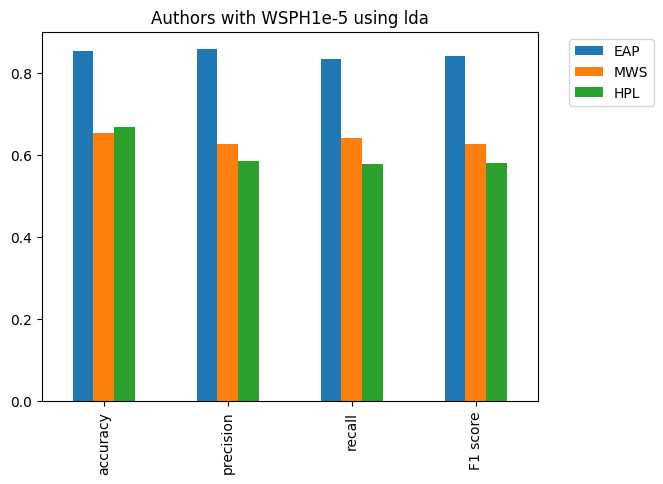

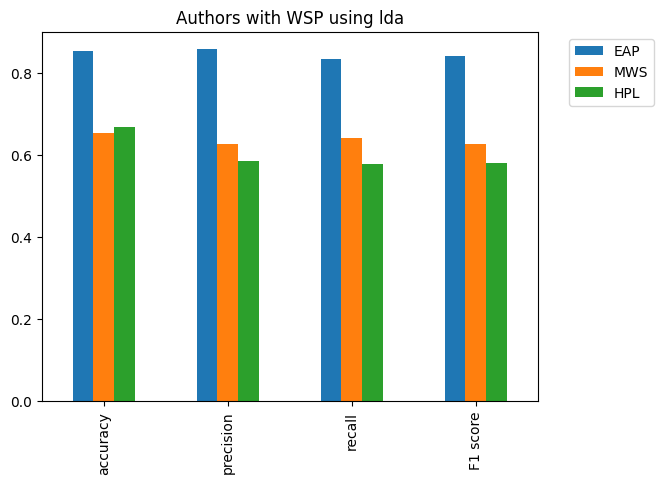

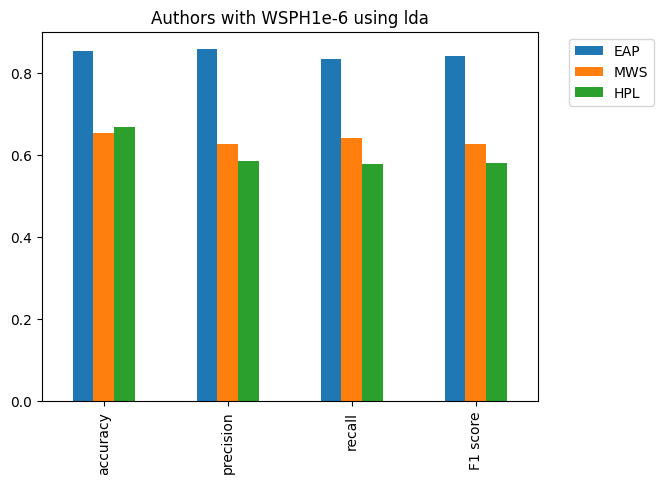

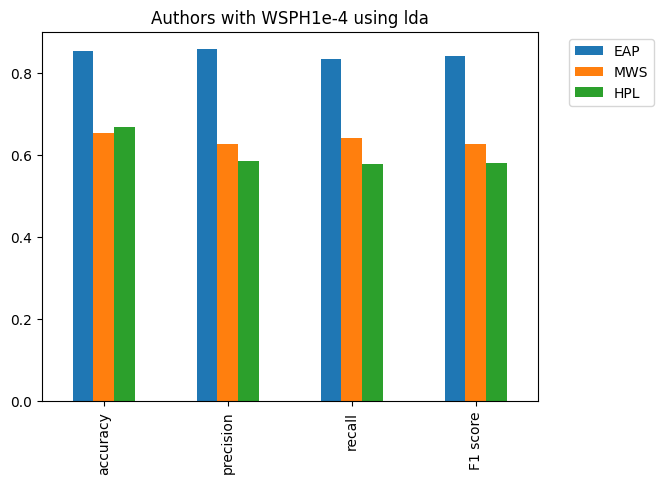

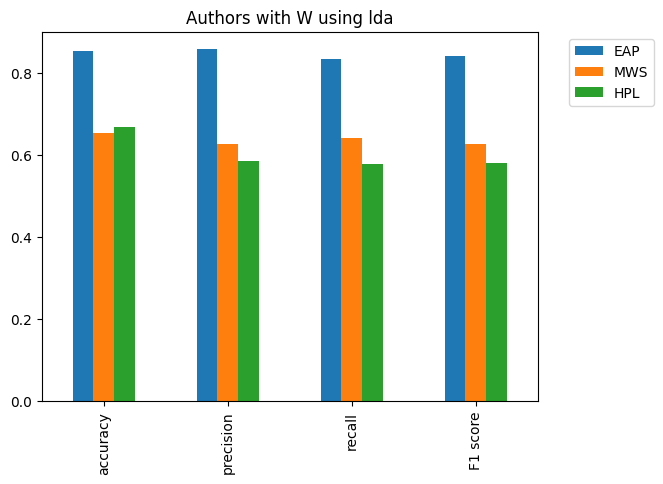

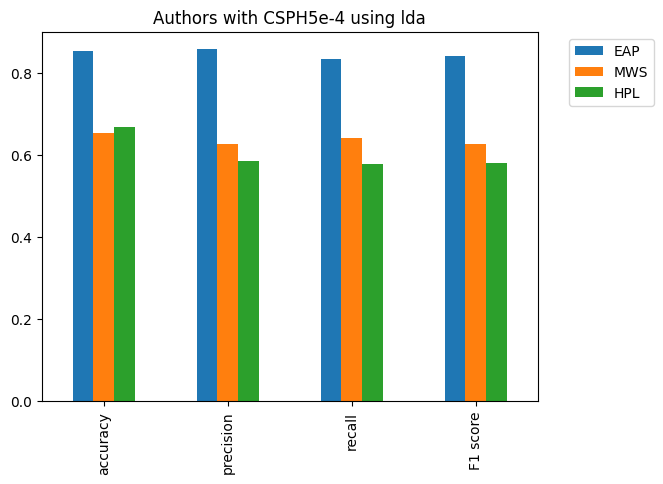

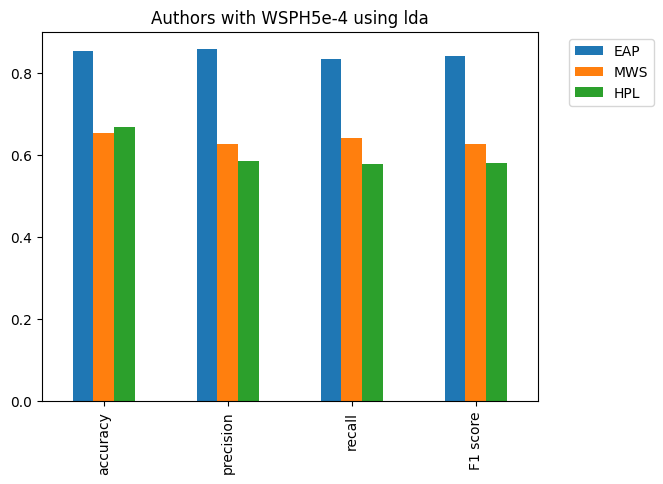

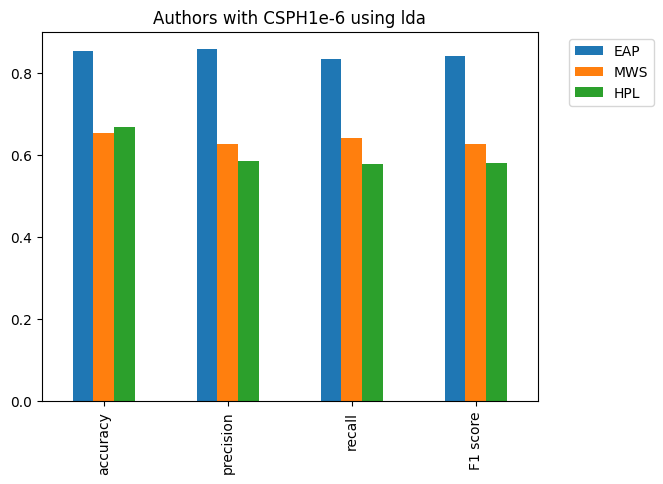

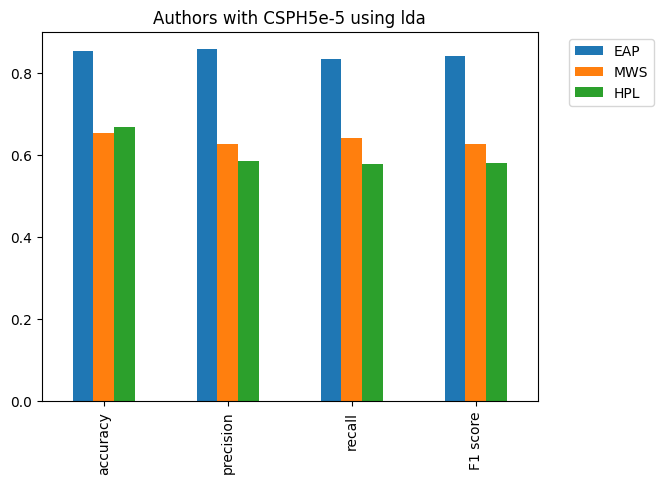

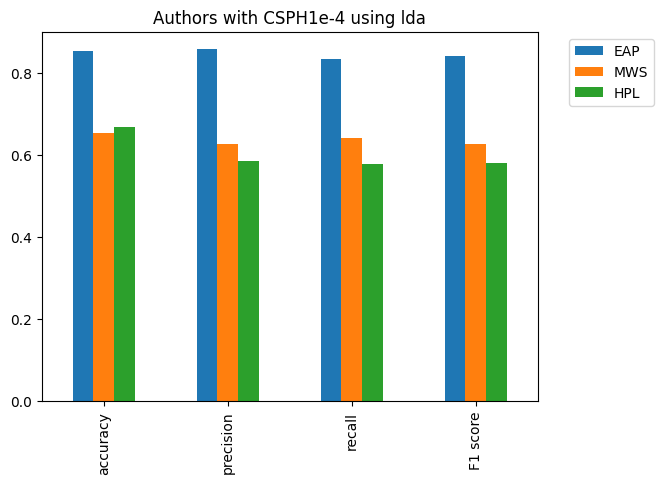

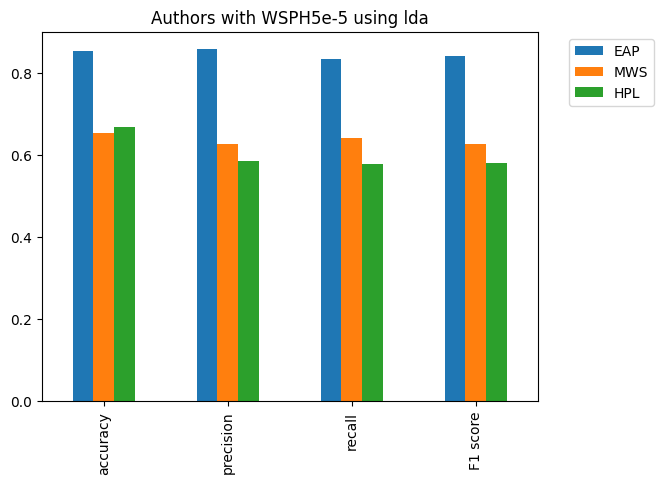

In [7]:
for method in ["bayes", "lda"]:
    method_df = df.loc[:, df.columns.str.contains(f"(author|{method})")]
    for preprocessing in range(2,int((len(method_df.columns)))):
        preprocess_name = re.sub(r".*\s(\S+)$", r"\1", method_df.columns[preprocessing])
        score_df = {}
        for author in ["EAP", "MWS", "HPL"]:
            author_df = pd.DataFrame(
                {"author": method_df["author"]})
            author_df = pd.concat([author_df, method_df.iloc[:, 1:].apply(
                lambda x: [1 if author == i else 0 for i in x])], axis=1)
            author_df = author_df.rename(columns=lambda x: re.sub(r".*\s(\S+)$", r"\1", x))
            score_df[author] = [func(author_df["author_short"],author_df.iloc[:, preprocessing]) for (name, func) in metrics]
        score_df = pd.DataFrame(score_df)
        score_df.index = ["accuracy", "precision", "recall", "F1 score"]
        score_df.plot.bar(title=f"Authors with {preprocess_name} using {method}")
        plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
        

In [8]:
for method in ["bayes", "lda"]:
    method_df = df.loc[:, df.columns.str.contains(f"(?=.*author)|(?=.*{method})")]
    for preprocessing in range(2,int((len(method_df.columns)))):
        preprocess_name = re.sub(r".*\s(\S+)$", r"\1", method_df.columns[preprocessing])
        display(method_df.groupby(["author_short", method_df.columns[preprocessing]]).size().unstack(fill_value=0))

bayes with WSP,EAP,HPL,MWS
author_short,,,
EAP,1143,167,233
HPL,92,411,642
MWS,80,397,751


bayes with WSPH1e-4,EAP,HPL,MWS
author_short,,,
EAP,1143,167,233
HPL,92,411,642
MWS,80,397,751


bayes with WSPH1e-5,EAP,HPL,MWS
author_short,,,
EAP,1143,167,233
HPL,92,411,642
MWS,80,397,751


bayes with C,EAP,HPL,MWS
author_short,,,
EAP,1143,167,233
HPL,92,411,642
MWS,80,397,751


bayes with W,EAP,HPL,MWS
author_short,,,
EAP,1143,167,233
HPL,92,411,642
MWS,80,397,751


bayes with WSPH1e-6,EAP,HPL,MWS
author_short,,,
EAP,1143,167,233
HPL,92,411,642
MWS,80,397,751


bayes with CSPH5e-4,EAP,HPL,MWS
author_short,,,
EAP,1143,167,233
HPL,92,411,642
MWS,80,397,751


bayes with CSPH1e-4,EAP,HPL,MWS
author_short,,,
EAP,1143,167,233
HPL,92,411,642
MWS,80,397,751


bayes with WL,EAP,HPL,MWS
author_short,,,
EAP,1143,167,233
HPL,92,411,642
MWS,80,397,751


bayes with CSPH1e-6,EAP,HPL,MWS
author_short,,,
EAP,1143,167,233
HPL,92,411,642
MWS,80,397,751


bayes with CSPH5e-5,EAP,HPL,MWS
author_short,,,
EAP,1143,167,233
HPL,92,411,642
MWS,80,397,751


bayes with WSPH5e-5,EAP,HPL,MWS
author_short,,,
EAP,1143,167,233
HPL,92,411,642
MWS,80,397,751


bayes with CSPH1e-5,EAP,HPL,MWS
author_short,,,
EAP,1143,167,233
HPL,92,411,642
MWS,80,397,751


bayes with WSPH5e-4,EAP,HPL,MWS
author_short,,,
EAP,1143,167,233
HPL,92,411,642
MWS,80,397,751


bayes with CSP,EAP,HPL,MWS
author_short,,,
EAP,1143,167,233
HPL,92,411,642
MWS,80,397,751


lda with CSP,EAP,HPL,MWS
author_short,,,
EAP,1143,167,233
HPL,92,411,642
MWS,80,397,751


lda with CSPH1e-5,EAP,HPL,MWS
author_short,,,
EAP,1143,167,233
HPL,92,411,642
MWS,80,397,751


lda with WL,EAP,HPL,MWS
author_short,,,
EAP,1143,167,233
HPL,92,411,642
MWS,80,397,751


lda with C,EAP,HPL,MWS
author_short,,,
EAP,1143,167,233
HPL,92,411,642
MWS,80,397,751


lda with WSPH1e-5,EAP,HPL,MWS
author_short,,,
EAP,1143,167,233
HPL,92,411,642
MWS,80,397,751


lda with WSP,EAP,HPL,MWS
author_short,,,
EAP,1143,167,233
HPL,92,411,642
MWS,80,397,751


lda with WSPH1e-6,EAP,HPL,MWS
author_short,,,
EAP,1143,167,233
HPL,92,411,642
MWS,80,397,751


lda with WSPH1e-4,EAP,HPL,MWS
author_short,,,
EAP,1143,167,233
HPL,92,411,642
MWS,80,397,751


lda with W,EAP,HPL,MWS
author_short,,,
EAP,1143,167,233
HPL,92,411,642
MWS,80,397,751


lda with CSPH5e-4,EAP,HPL,MWS
author_short,,,
EAP,1143,167,233
HPL,92,411,642
MWS,80,397,751


lda with WSPH5e-4,EAP,HPL,MWS
author_short,,,
EAP,1143,167,233
HPL,92,411,642
MWS,80,397,751


lda with CSPH1e-6,EAP,HPL,MWS
author_short,,,
EAP,1143,167,233
HPL,92,411,642
MWS,80,397,751


lda with CSPH5e-5,EAP,HPL,MWS
author_short,,,
EAP,1143,167,233
HPL,92,411,642
MWS,80,397,751


lda with CSPH1e-4,EAP,HPL,MWS
author_short,,,
EAP,1143,167,233
HPL,92,411,642
MWS,80,397,751


lda with WSPH5e-5,EAP,HPL,MWS
author_short,,,
EAP,1143,167,233
HPL,92,411,642
MWS,80,397,751


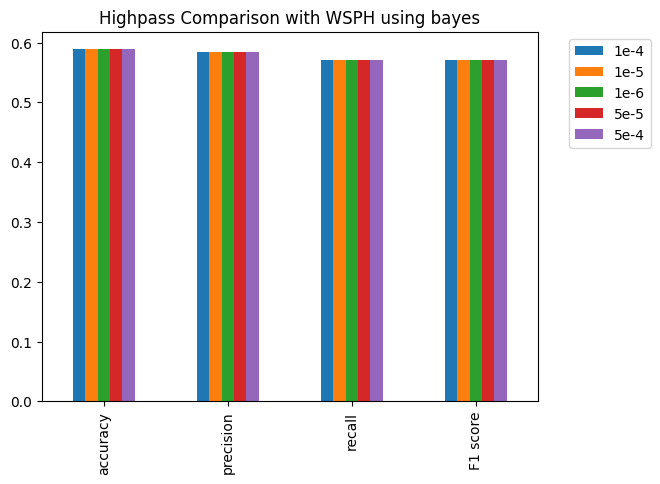

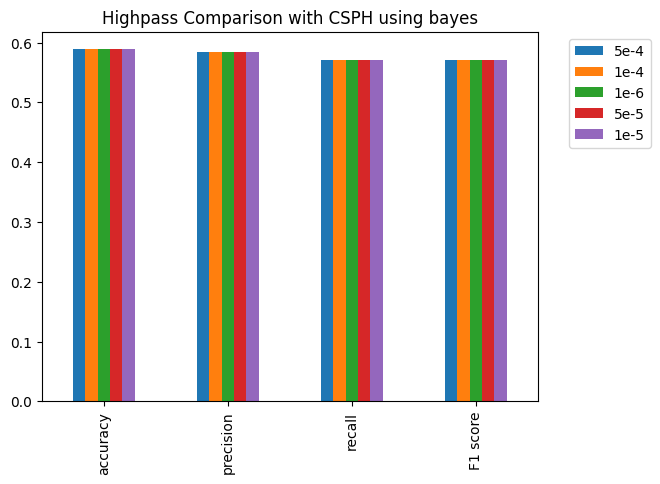

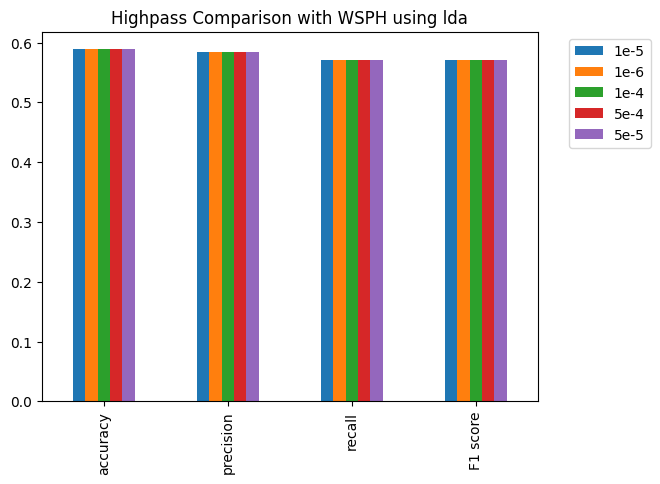

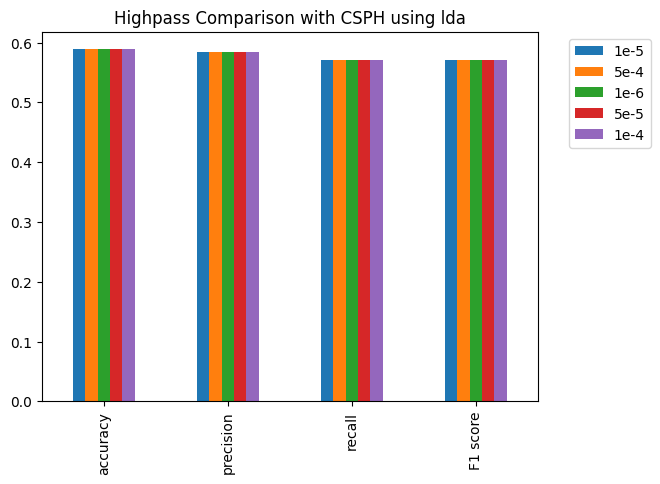

In [9]:
for method in ["bayes", "lda"]:
    for preprocessing in ["WSPH", "CSPH"]:
        method_df = df.loc[:, df.columns.str.contains(f"(?=.*author)|(?=.*{method})(?=.*{preprocessing})")]
        method_df = method_df.rename(columns=lambda x: re.sub(r".*\s(\S+)$", r"\1", x))
        score_df = method_df.iloc[: , 2:].apply(lambda x: [accuracy_score(x, method_df["author_short"]), precision_score(method_df["author_short"], x, average="macro"), recall_score(method_df["author_short"], x, average="macro"), f1_score(method_df["author_short"], x, average="macro")])
        score_df.index = ["accuracy", "precision", "recall", "F1 score"]
        score_df = score_df.rename(columns=lambda x: re.sub(r'^\D*(\d.*)', r'\1', x))
        score_df.plot.bar(title=f"Highpass Comparison with {preprocessing} using {method}")
        plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

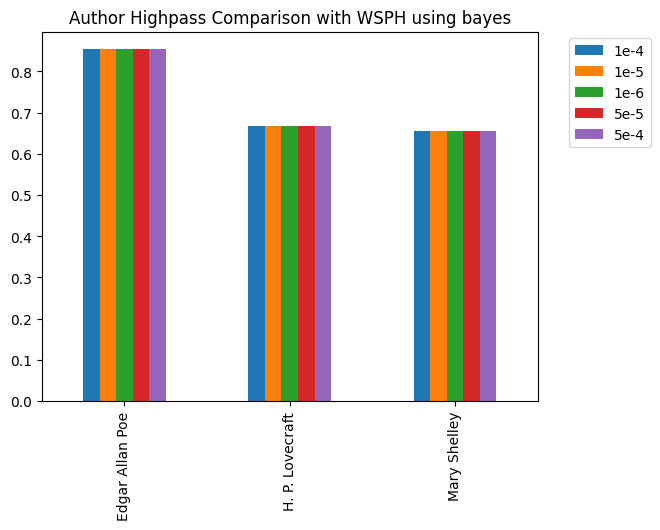

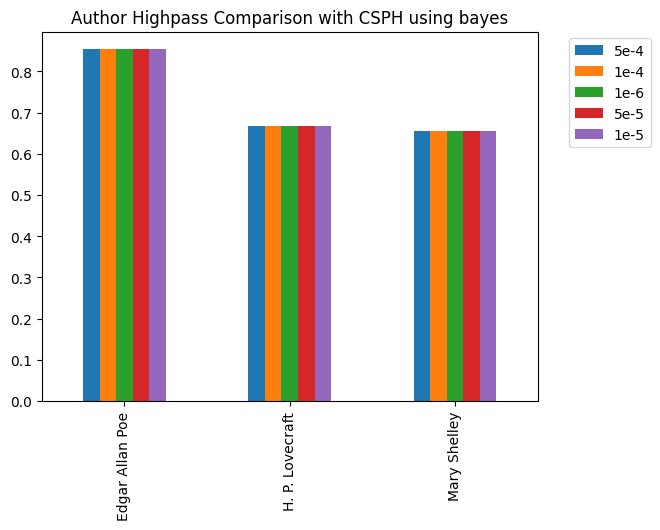

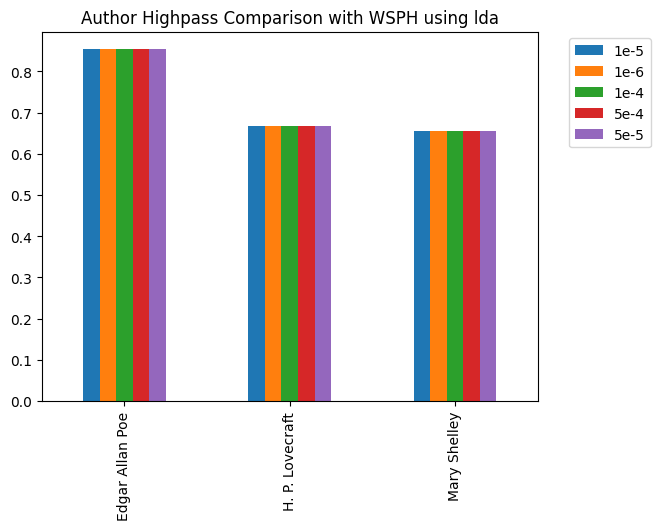

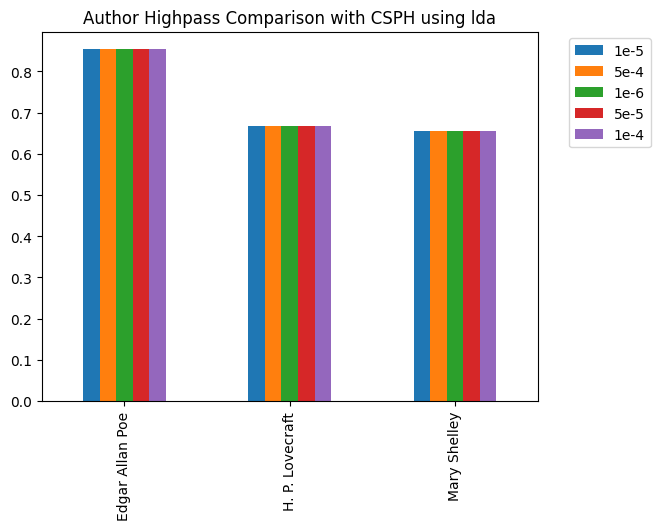

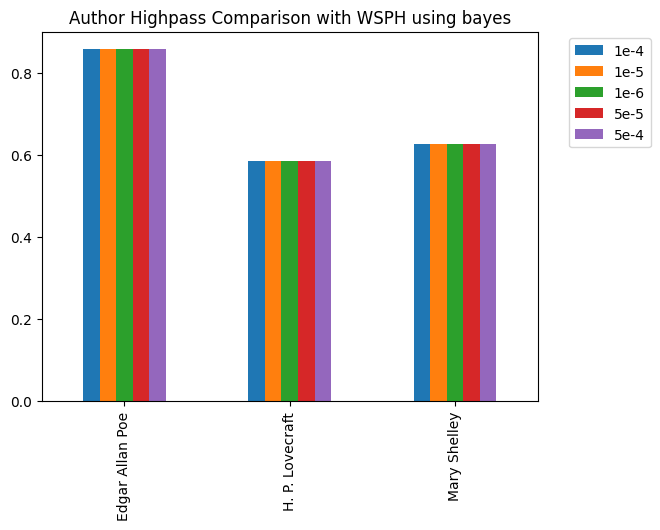

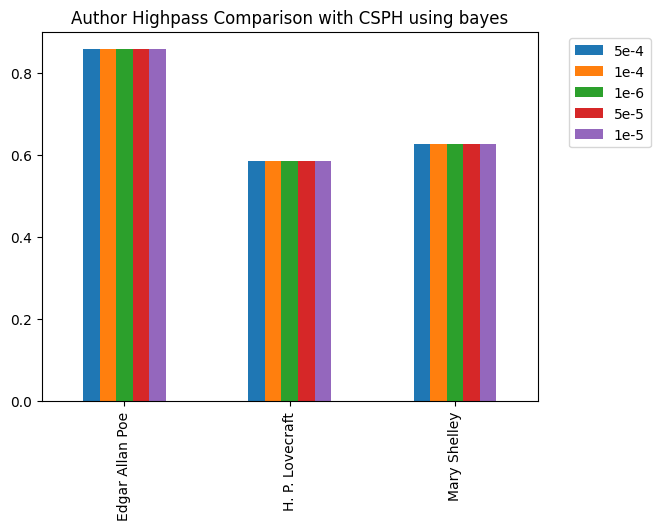

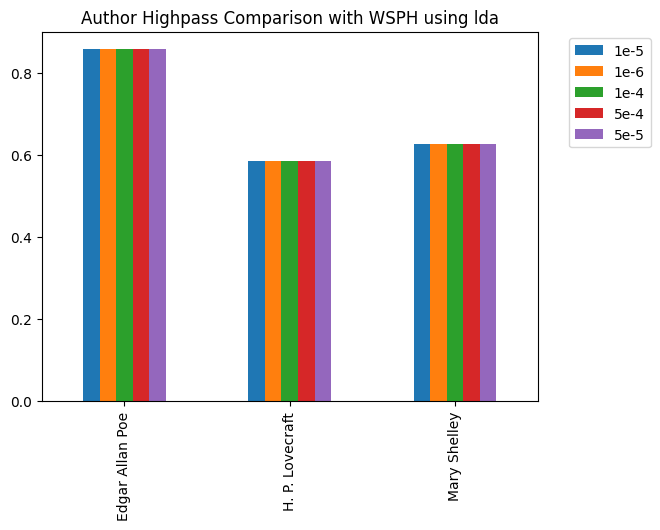

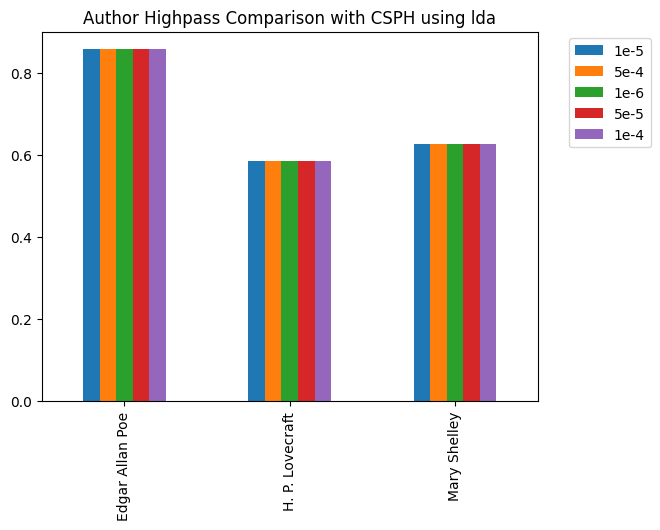

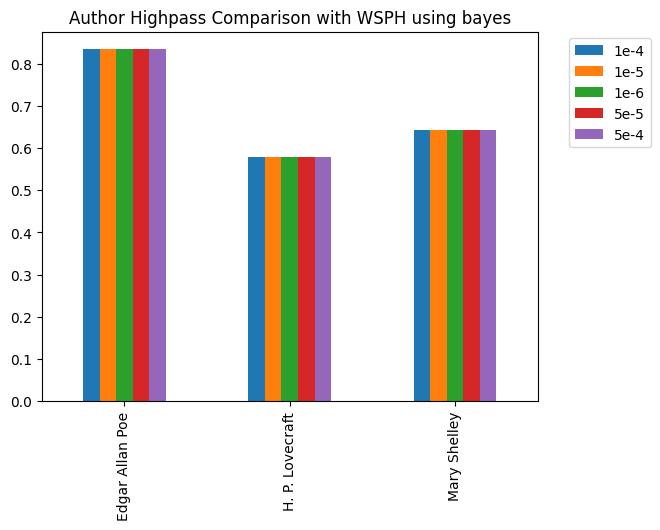

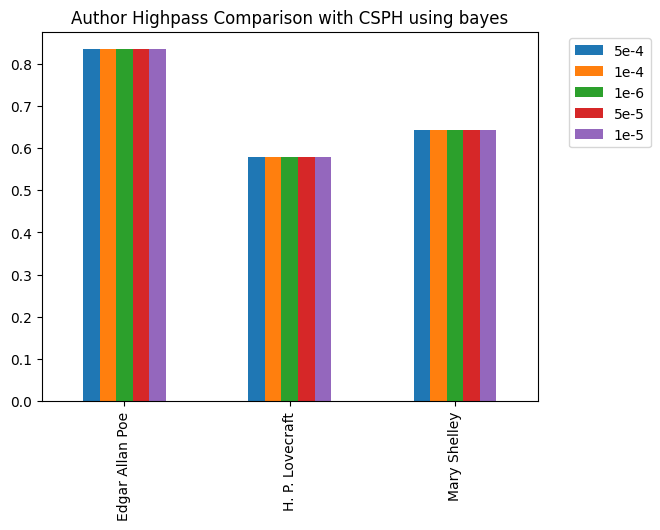

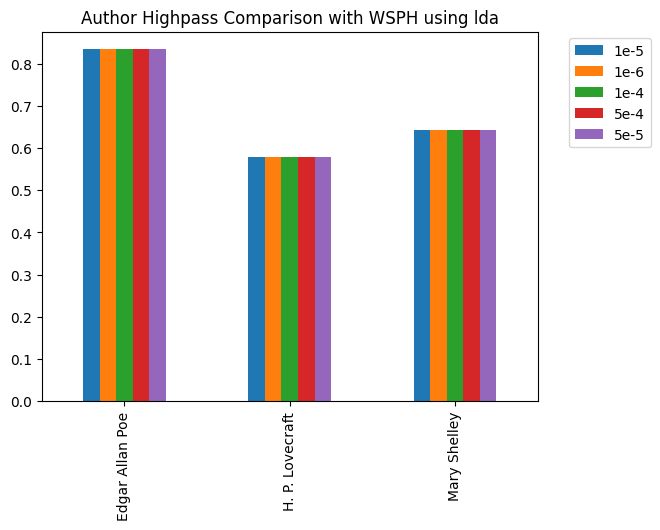

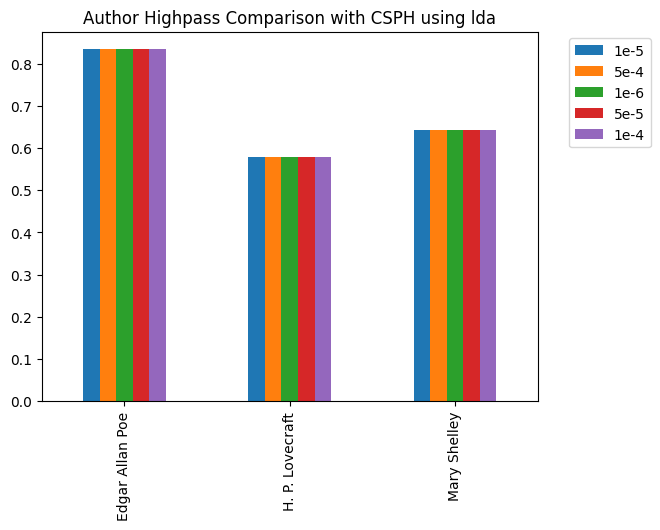

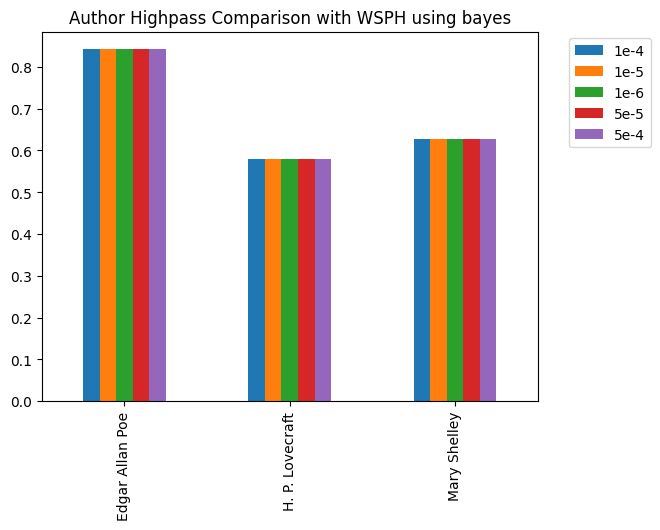

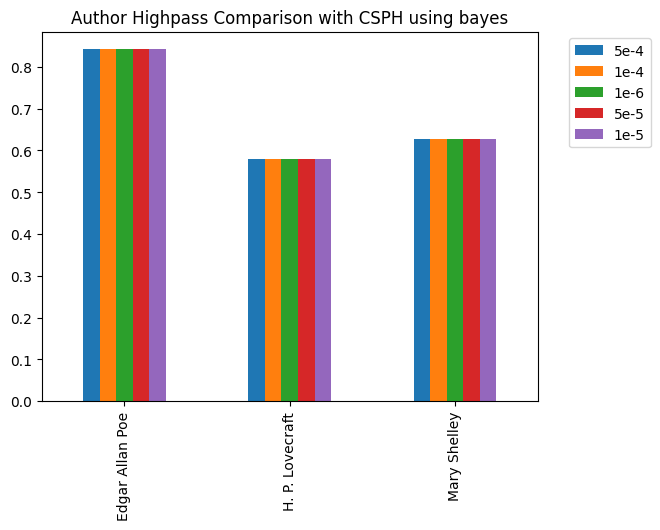

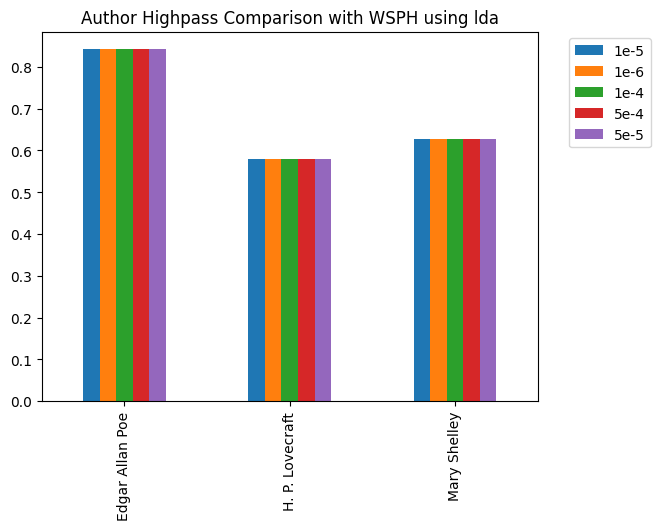

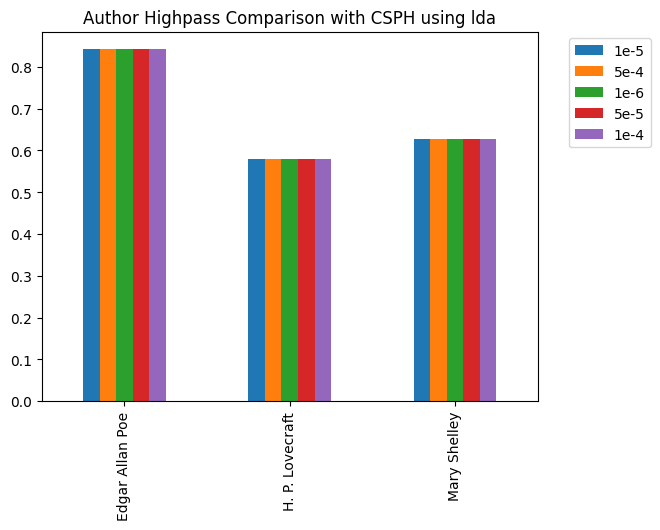

In [10]:
for (name, func) in metrics:
    for method in ["bayes", "lda"]:
        for preprocessing in ["WSPH", "CSPH"]:
            method_df = df.loc[:, df.columns.str.contains(f"(?=.*author)|(?=.*{method})(?=.*{preprocessing})")]
            cutoffs = defaultdict(lambda: [])
            for author in ["EAP", "HPL", "MWS"]:
                author_df = pd.DataFrame(
                    {"author": method_df["author"]})
                author_df = pd.concat([author_df, method_df.iloc[:, 1:].apply(
                    lambda x: [1 if author == i else 0 for i in x])], axis=1)
                for cutoff in range(2,int(len(author_df.columns))):
                    cutoffs[author_df.columns[cutoff]].append(func(author_df["author_short"], author_df.iloc[:, cutoff]))
            cutoffs = pd.DataFrame(cutoffs)
            cutoffs.index = [authors_short_dict[author] for author in ["EAP", "HPL", "MWS"]]
            cutoffs = cutoffs.rename(columns=lambda x: re.sub(r'^\D*(\d.*)', r'\1', x))
            cutoffs.plot.bar(title=f"Author Highpass Comparison with {preprocessing} using {method}")
            plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')


In [11]:
total_table = pd.DataFrame()
for (name, func) in metrics:
    for method in ["bayes", "lda"]:
        authors = defaultdict(lambda: [])
        for author in ["EAP", "HPL", "MWS"]:
            method_df = df.loc[:, df.columns.str.contains(f"(?=.*author)|(?=.*{method})")]
            author_df = pd.DataFrame({"author": method_df["author"]})
            author_df = pd.concat([author_df, method_df.iloc[:, 1:].apply(
                    lambda x: [1 if author == i else 0 for i in x])], axis=1) 
            author_df = author_df.rename(columns=lambda x: re.sub(r".*\s(\S+)$", r"\1", x))
            authors[author] = author_df.iloc[:, 2:].apply(lambda x: func(author_df["author_short"], x))
        authors = pd.DataFrame(authors)
        total_table = pd.concat([total_table, authors], axis=1)
pd.set_option('display.max_columns', None)
total_table.columns = pd.MultiIndex.from_product([map(lambda x: x[0], metrics), ["bayes", "lda"], ["EAP", "HPL", "MWS"]])
total_table

Accuracy                                                 Precision  \
             bayes                          lda                        bayes   
               EAP       HPL      MWS       EAP       HPL      MWS       EAP   
WSP       0.853933  0.668539  0.65475  0.853933  0.668539  0.65475  0.857707   
WSPH1e-4  0.853933  0.668539  0.65475  0.853933  0.668539  0.65475  0.857707   
WSPH1e-5  0.853933  0.668539  0.65475  0.853933  0.668539  0.65475  0.857707   
C         0.853933  0.668539  0.65475  0.853933  0.668539  0.65475  0.857707   
W         0.853933  0.668539  0.65475  0.853933  0.668539  0.65475  0.857707   
WSPH1e-6  0.853933  0.668539  0.65475  0.853933  0.668539  0.65475  0.857707   
CSPH5e-4  0.853933  0.668539  0.65475  0.853933  0.668539  0.65475  0.857707   
CSPH1e-4  0.853933  0.668539  0.65475  0.853933  0.668539  0.65475  0.857707   
WL        0.853933  0.668539  0.65475  0.853933  0.668539  0.65475  0.857707   
CSPH1e-6  0.853933  0.668539  0.65475  0.853933  0.668539  0.65475  0.857707   
CSPH5e-5  0.853933  0.668539  0.65475  0.853933  0.668539  0.65475  0.857707   
WSPH5e-5  0.853933  0.668539  0.65475  0.853933  0.668539  0.65475  0.857707   
CSPH1e-5  0.853933  0.668539  0.65475  0.853933  0.668539  0.65475  0.857707   
WSPH5e-4  0.853933  0.668539  0.65475  0.853933  0.668539  0.65475  0.857707   
CSP       0.853933  0.668539  0.65475  0.853933  0.668539  0.65475  0.857707   

                                                              Recall  \
                                   lda                         bayes   
               HPL       MWS       EAP       HPL       MWS       EAP   
WSP       0.585982  0.626786  0.857707  0.585982  0.626786  0.834141   
WSPH1e-4  0.585982  0.626786  0.857707  0.585982  0.626786  0.834141   
WSPH1e-5  0.585982  0.626786  0.857707  0.585982  0.626786  0.834141   
C         0.585982  0.626786  0.857707  0.585982  0.626786  0.834141   
W         0.585982  0.626786  0.857707  0.585982  0.626786  0.834141   
WSPH1e-6  0.585982  0.626786  0.857707  0.585982  0.626786  0.834141   
CSPH5e-4  0.585982  0.626786  0.857707  0.585982  0.626786  0.834141   
CSPH1e-4  0.585982  0.626786  0.857707  0.585982  0.626786  0.834141   
WL        0.585982  0.626786  0.857707  0.585982  0.626786  0.834141   
CSPH1e-6  0.585982  0.626786  0.857707  0.585982  0.626786  0.834141   
CSPH5e-5  0.585982  0.626786  0.857707  0.585982  0.626786  0.834141   
WSPH5e-5  0.585982  0.626786  0.857707  0.585982  0.626786  0.834141   
CSPH1e-5  0.585982  0.626786  0.857707  0.585982  0.626786  0.834141   
WSPH5e-4  0.585982  0.626786  0.857707  0.585982  0.626786  0.834141   
CSP       0.585982  0.626786  0.857707  0.585982  0.626786  0.834141   

                                                            F1 Score  \
                                   lda                         bayes   
               HPL       MWS       EAP       HPL       MWS       EAP   
WSP       0.577708  0.643021  0.834141  0.577708  0.643021  0.842431   
WSPH1e-4  0.577708  0.643021  0.834141  0.577708  0.643021  0.842431   
WSPH1e-5  0.577708  0.643021  0.834141  0.577708  0.643021  0.842431   
C         0.577708  0.643021  0.834141  0.577708  0.643021  0.842431   
W         0.577708  0.643021  0.834141  0.577708  0.643021  0.842431   
WSPH1e-6  0.577708  0.643021  0.834141  0.577708  0.643021  0.842431   
CSPH5e-4  0.577708  0.643021  0.834141  0.577708  0.643021  0.842431   
CSPH1e-4  0.577708  0.643021  0.834141  0.577708  0.643021  0.842431   
WL        0.577708  0.643021  0.834141  0.577708  0.643021  0.842431   
CSPH1e-6  0.577708  0.643021  0.834141  0.577708  0.643021  0.842431   
CSPH5e-5  0.577708  0.643021  0.834141  0.577708  0.643021  0.842431   
WSPH5e-5  0.577708  0.643021  0.834141  0.577708  0.643021  0.842431   
CSPH1e-5  0.577708  0.643021  0.834141  0.577708  0.643021  0.842431   
WSPH5e-4  0.577708  0.643021  0.834141  0.577708  0.643021  0.842431   
CSP       0.577708  0.643021  0.834141  0.577708